# 1) Coleta de Dados IPEA DATA

Os dados do PIB real foram coletados de duas formas, uma via download direto do arquivo excel e outra de uma API que traz os dados mais atualiados.


=> http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38414

## 1.1) Dados Planilha PIB, Consumo, Saldo BC e Serviçõs/PIB e EMBI+

In [9]:
# A planilha está na pasta dados.

import os
import pandas as pd
import math
from tabulate import tabulate
diretorio = os.path.dirname(os.getcwd())
local_arquivo = os.path.join(diretorio,
                             'dados',
                             'Dados.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo)

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe pib_pm_deflacionado_ipca
dataframe.index = pd.date_range('1996-03',
                      periods=len(dataframe['PIB  precos de mercado IPCA']),
                      freq='Q')

# Log Das Variaveis
dataframe['PIB  precos de mercado IPCA Sem Log'] = [pib for pib in dataframe['PIB  precos de mercado IPCA'].values]
dataframe['PIB  precos de mercado IPCA'] = [math.log(pib) for pib in dataframe['PIB  precos de mercado IPCA'].values]
dataframe['PIB  consumo final  familias  IPCA Sem Log'] = [pib for pib in dataframe['PIB  consumo final  familias  IPCA'].values]
dataframe['PIB  consumo final  familias  IPCA'] = [math.log(pib) for pib in dataframe['PIB  consumo final  familias  IPCA'].values]



#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
pib_pm_deflacionado_ipca_sem_log = dataframe['PIB  precos de mercado IPCA Sem Log']
pib_pm_deflacionado_ipca = dataframe['PIB  precos de mercado IPCA']

#selecionando a coluna consumo a preços de marcado deflacionado pelo IPCA
consumo_deflacionado_ipca_sem_log = dataframe['PIB  consumo final  familias  IPCA Sem Log']
consumo_deflacionado_ipca = dataframe['PIB  consumo final  familias  IPCA']

#selecionando a coluna exportação a preços de marcado deflacionado pelo IPCA
exportação_deflacionado_ipca = dataframe['PIB – exportações precos de mercado IPCA']
importação_deflacionado_ipca = dataframe['PIB – importações precos de mercado IPCA']

#selecionando a coluna importação a preços de marcado deflacionado pelo IPCA
dataframe['EMBI Média'] = [(pontosbase/10000) for pontosbase in dataframe['EMBI Média']]
dataframe['EMBI Fim de Período'] = [pontosbase/10000 for pontosbase in dataframe['EMBI Fim de Período']]
dataframe['EMBI Fim de Período'] = [embi - dataframe['EMBI Fim de Período'].mean() for embi in dataframe['EMBI Fim de Período']]

#selecionando a coluna importação a preços de marcado deflacionado pelo IPCA
embi_media = dataframe['EMBI Média']
embi_fim_periodo = dataframe['EMBI Fim de Período']

#correlation_dataframe = pd.concat([correlation_dataframe, dataframe['PIB  precos de mercado IPCA Sem Log']], axis=1, sort=False)
#correlation_dataframe = pd.concat([correlation_dataframe, embi_fim_periodo], axis=1, sort=False)


## 1.2) Dados Planilha Juros Americanos

In [10]:
# A planilha de juros está na pasta dados.

local_arquivo_juros = os.path.join(diretorio,
                             'dados',
                             'Taxa de Juros Americanos Trimestre.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo_juros)

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe juro_americanos
dataframe.index = pd.date_range('1962-10',
                      periods=len(dataframe['DGS10 media']),
                      freq='Q')


dataframe['DGS10 media trimetral'] = [(((taxa/100)+1)**(1/4) - 1)*100 for taxa in dataframe['DGS10 media'].values]
dataframe['DGS10 fim periodo trimestral'] = [(((taxa/100)+1)**(1/4) - 1)*100 for taxa in dataframe['DGS10 fim periodo'].values]

#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
taxa_juros_americanos_media = dataframe['DGS10 media']
taxa_juros_americanos_fim_periodo = dataframe['DGS10 fim periodo']

dataframe_juros_americanos = dataframe

# 2) Dessazonalizar Séries PIB, Consumo, Exportação e Importação

Abaixo coloquei a documentação do ajuste de sazonalidade x13
https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_analysis.html

In [12]:
# Pacote statsmodels que possui o x13
import statsmodels.tsa as sm

#precisei baixar um arquivo do site census pra poder a ajuste ser feito
#abaixo esta o site e o stackoverflow tirando duvidas sobre como fazer funcionar o ajuste no pyhton
#https://www.census.gov/srd/www/x13as/
#https://stackoverflow.com/questions/32053770/arima-seasonal-prediction-with-python-x12a-and-x13as-not-found-on-path

#coloquei o aquivo no numa pasta chamada x13 dentro do diretorio do notebook
local_x13_seassonal_file = os.path.join(diretorio,
                                        'notebook',
                                        'x13',
                                        'x13as')

#execução do ajuste no pib consumo importação e exportação
pib_pm_deflacionado_ipca_dessazonalizado_sem_log = sm.x13.x13_arima_analysis(pib_pm_deflacionado_ipca_sem_log,x12path=local_x13_seassonal_file)
pib_pm_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(pib_pm_deflacionado_ipca,x12path=local_x13_seassonal_file)
consumo_deflacionado_ipca_dessazonalizado_sem_log = sm.x13.x13_arima_analysis(consumo_deflacionado_ipca_sem_log,x12path=local_x13_seassonal_file)
consumo_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(consumo_deflacionado_ipca,x12path=local_x13_seassonal_file)
exportacao_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(exportação_deflacionado_ipca,x12path=local_x13_seassonal_file)
importacao_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(importação_deflacionado_ipca,x12path=local_x13_seassonal_file)


dataframe_pib_pm_deflacionado_ipca_dessazonalizado_sem_log = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado_sem_log.seasadj)
dataframe_pib_pm_deflacionado_ipca_dessazonalizado_sem_log = dataframe_pib_pm_deflacionado_ipca_dessazonalizado_sem_log.rename(columns={'seasadj':'PIB Real Dessazonalizado Sem Log'})

dataframe_pib_pm_deflacionado_ipca_dessazonalizado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_pib_pm_deflacionado_ipca_dessazonalizado = dataframe_pib_pm_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'PIB Real Dessazonalizado'})

dataframe_consumo_deflacionado_ipca_dessazonalizado_sem_log = pd.DataFrame(consumo_deflacionado_ipca_dessazonalizado_sem_log.seasadj)
dataframe_consumo_deflacionado_ipca_dessazonalizado_sem_log = dataframe_consumo_deflacionado_ipca_dessazonalizado_sem_log.rename(columns={'seasadj':'Consumo Real Dessazonalizado Sem Log'})

dataframe_consumo_deflacionado_ipca_dessazonalizado = pd.DataFrame(consumo_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_consumo_deflacionado_ipca_dessazonalizado = dataframe_consumo_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'Consumo Real Dessazonalizado'})

dataframe_exportacao_deflacionado_ipca_dessazonalizado = pd.DataFrame(exportacao_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_exportacao_deflacionado_ipca_dessazonalizado = dataframe_exportacao_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'Exportacao Real Dessazonalizado'})

dataframe_importacao_deflacionado_ipca_dessazonalizado = pd.DataFrame(importacao_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_importacao_deflacionado_ipca_dessazonalizado = dataframe_importacao_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'Importacao Real Dessazonalizado'})

#Descomente para printar o ajuste
#pib_pm_deflacionado_ipca_dessazonalizado.seasadj



# Exportando os Dados de log do PIB e CONSUMO dessazonalizado para Excel
Tabela_Dessazonalizada = pd.concat([dataframe_pib_pm_deflacionado_ipca_dessazonalizado,
                                    dataframe_consumo_deflacionado_ipca_dessazonalizado], axis=1, sort=False)

## 2.1) Montanto Tabela das Correlações

In [13]:
correlation_dataframe = pd.concat([                        
           embi_fim_periodo,
           dataframe_pib_pm_deflacionado_ipca_dessazonalizado_sem_log,
           dataframe_exportacao_deflacionado_ipca_dessazonalizado,
           dataframe_importacao_deflacionado_ipca_dessazonalizado], axis=1, sort=False)


## 2.1.1) Criando a Serie Saldo BC/PIB com as variaveis dessazonalizadas

In [14]:
correlation_dataframe['Saldo BC/PIB %'] = (correlation_dataframe['Exportacao Real Dessazonalizado'] - correlation_dataframe['Importacao Real Dessazonalizado'])/correlation_dataframe['PIB Real Dessazonalizado Sem Log']
correlation_dataframe['Saldo BC/PIB %'] = [saldo - correlation_dataframe['Saldo BC/PIB %'].mean() for saldo in  correlation_dataframe['Saldo BC/PIB %']]

In [15]:
correlation_dataframe = correlation_dataframe.drop(columns=['Exportacao Real Dessazonalizado'])
correlation_dataframe = correlation_dataframe.drop(columns=['Importacao Real Dessazonalizado'])
correlation_dataframe = correlation_dataframe.drop(columns=['PIB Real Dessazonalizado Sem Log'])

## 2.1) Plot das Series

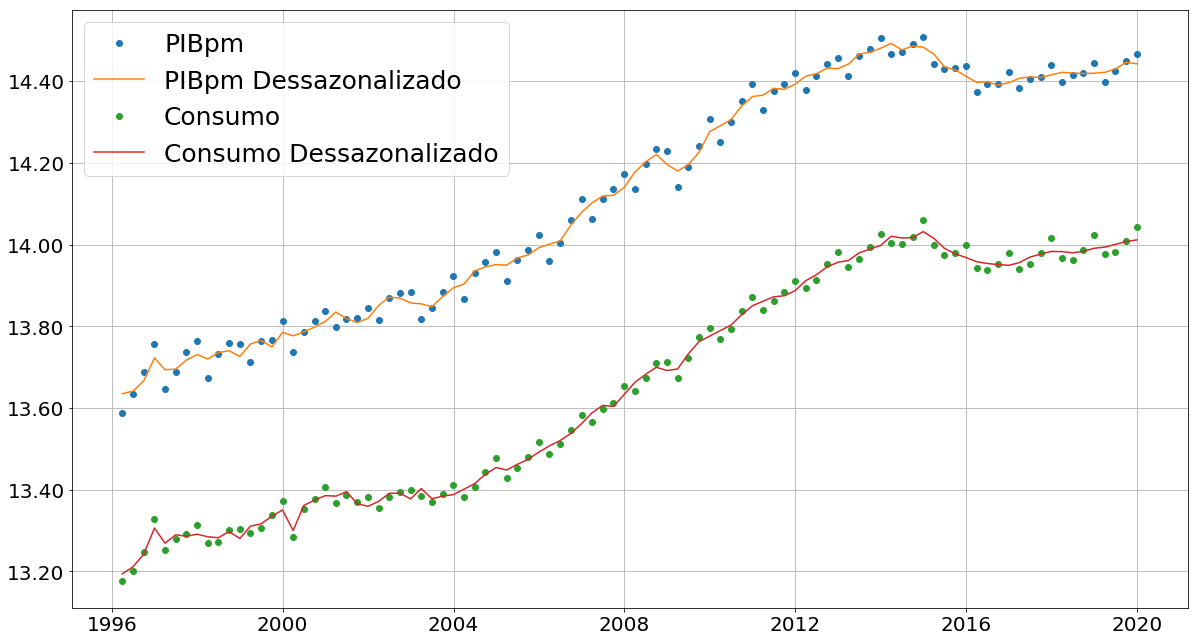

In [17]:
#pacotes de gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot da Serie original
ax.plot(pib_pm_deflacionado_ipca.index,
        pib_pm_deflacionado_ipca.values,'o',label='PIBpm')

# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado.seasadj.index,
        pib_pm_deflacionado_ipca_dessazonalizado.seasadj.values,label='PIBpm Dessazonalizado')

# Plot da Serie original Consumo
ax.plot(consumo_deflacionado_ipca.index,
        consumo_deflacionado_ipca.values,'o',label='Consumo')

# Plot da Serie Com Ajuste Sazonal Consump
ax.yaxis.set_major_formatter(tick) 
ax.plot(consumo_deflacionado_ipca_dessazonalizado.seasadj.index,
        consumo_deflacionado_ipca_dessazonalizado.seasadj.values,label='Consumo Dessazonalizado')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legendas
ax.legend(loc="upper left",fontsize=25)


## Plot Balança Comercial/PIB

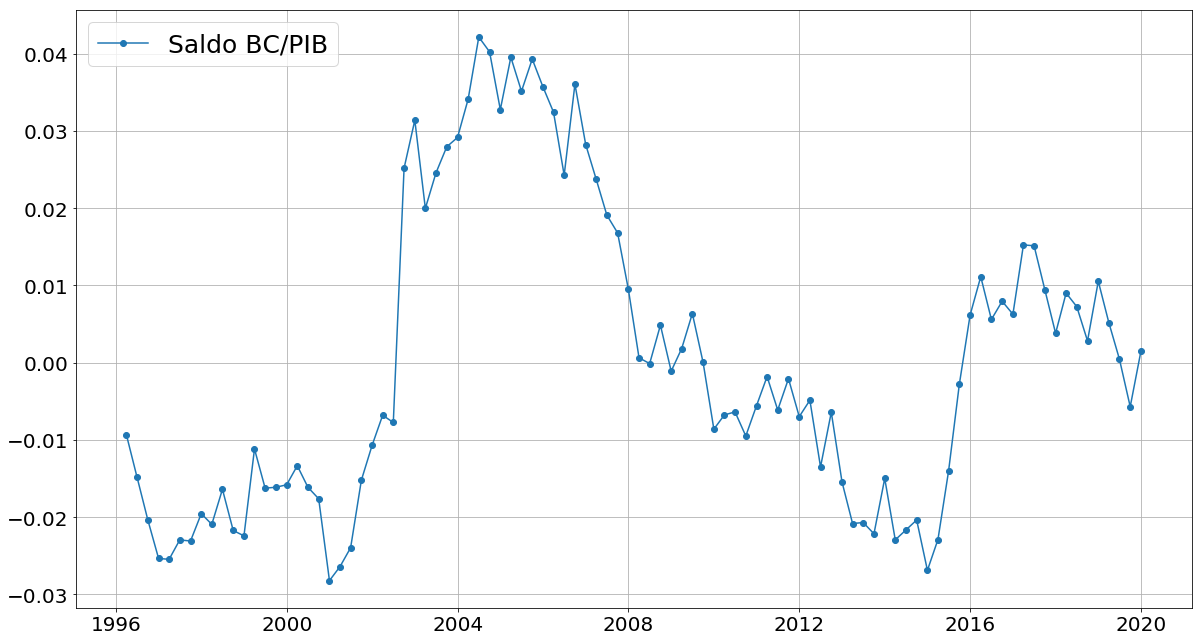

In [18]:
#pacotes de gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot da Serie original
ax.plot(correlation_dataframe['Saldo BC/PIB %'].index,
        correlation_dataframe['Saldo BC/PIB %'].values,'-o',label='Saldo BC/PIB')


# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",fontsize=25)

# 3) Aplicando Filtros  

## 3.1) Band Pass - Baxter and King
https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_filters.html

No call que fizemos eu nao me lembrava onde tinha visto sobre esse filtro. 
https://www.researchgate.net/publication/24111493_Measuring_Business_Cycles_The_Real_Business_Cycle_Approach_and_Related_Controversies

Quando comecei o a rodar os modelos em 2016 eu ja conhecia esse filtro, mas se não me engano na época eu perdia parte inicial e final da amostra. Mas tinha compreendido errado o que é calibração. Se entendi bem a ideia desses tipos de modelos DSGE é replicar o primeiro e o segundo momento o mais proximo da realidade da amostra.


Site com explicações do pacote
https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.bk_filter.bkfilter.html

In [19]:
# Pacode de Display de tabela em HTML
from IPython.core.display import display, HTML
#Pacote com o filtro Baxter King => sm.filters.bk_filter.bkfilter()
# pib_pm_deflacionado_ipca_dessazonalizado.seasadj é o resultado do ajuste x13
# seasadj chama os objeto com as datas e os valores
# low = O período mínimo para oscilações. Baxter e King sugerem que o ciclo de negócios calculados por Burns-Mitchell nos EUA tenha 6 para dados trimestrais e 1,5 para dados anuais.
# high = Período máximo para oscilações BK sugere que o ciclo de negócios nos EUA tenha 32 para dados trimestrais e 8 para dados anuais.
pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk = sm.filters.bk_filter.bkfilter(pib_pm_deflacionado_ipca_dessazonalizado.seasadj,
                                                                                     low=6,
                                                                                     high=32,
                                                                                     K=12)
consumo_deflacionado_ipca_dessazonalizado_filtrado_bk = sm.filters.bk_filter.bkfilter(consumo_deflacionado_ipca_dessazonalizado.seasadj,
                                                                                     low=6,
                                                                                     high=32,
                                                                                     K=12)



# o retorno é um vetor [array] com os componetes ciclicos serie x. Descomente a linhade baixo para printar
df_pib_filtrado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk)
# Dando nome a coluna de datas
df_pib_filtrado.index.name = "Data"
# transformando a tabela em HTML 
pib_filtrado_tabela_HTML = tabulate(df_pib_filtrado, tablefmt="html")
# descomente para printar a tabela
#display(HTML(pib_filtrado_tabela_HTML))
#df_pib_filtrado


## 3.2) Christiano Fitzgerald asymmetric, random walk filter.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.cf_filter.cffilter.html#statsmodels.tsa.filters.cf_filter.cffilter

O filtro Christiano-Fitzgerald é uma generalização de BK e, portanto, também pode ser visto como média móvel ponderada.

os parametros low e high seguem as mesmas especificações do filtro BK

o parametro drift é a tendência dos dados. A tendência é estimada como np.arange (nobs) * (x [-1] - x [0]) / (len (x) -1).

In [20]:
# Com drift
pib_cf_filter_cycle_cf_drift, pib_cf_filter_trend_cf_drift = sm.filters.cf_filter.cffilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['PIB Real Dessazonalizado'],
                                           low=6,
                                           high=32,
                                           drift=True)

# Sem drift
pib_cf_filter_cycle_cf_drift_s, pib_cf_filter_trend_cf_drift_s = sm.filters.cf_filter.cffilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['PIB Real Dessazonalizado'],
                                           low=6,
                                           high=32,
                                           drift=False)


# Com drift
consumo_cf_filter_cycle_cf_drift, consumo_cf_filter_trend_cf_drift = sm.filters.cf_filter.cffilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['Consumo Real Dessazonalizado'],
                                           low=6,
                                           high=32,
                                           drift=True)

# Sem drift
consumo_cf_filter_cycle_cf_drift_s, consumo_cf_filter_trend_cf_drift_s = sm.filters.cf_filter.cffilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['Consumo Real Dessazonalizado'],
                                           low=6,
                                           high=32,
                                           drift=False)

## 3.3) HP simples

In [21]:
pib_hp_filter_cycle, pib_hp_filter_trend = sm.filters.hp_filter.hpfilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['PIB Real Dessazonalizado'],
                                                                               1600)

consumo_hp_filter_cycle, consumo_hp_filter_trend = sm.filters.hp_filter.hpfilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['Consumo Real Dessazonalizado'],
                                                                               1600)

## 3.4) Primeira Diferença (É assim?)

Vi que tem e especificação desse modelo no Arquivo do Pfeifer, mas nao li com detelhe e assumi que o filtro primeira diferença fosse somente a amostra atual menos a mostra defasada t-1.

In [22]:
pib_deflacionado_primeira_diferenca = dataframe_pib_pm_deflacionado_ipca_dessazonalizado['PIB Real Dessazonalizado'].diff()

consumo_deflacionado_primeira_diferenca = dataframe_consumo_deflacionado_ipca_dessazonalizado['Consumo Real Dessazonalizado'].diff()

# 3.5) Arquivo Filtrado enviado pelo Paulo

In [23]:
local_arquivo_filtrado = os.path.join(diretorio,
                             'dados',
                             'Tabela_Detrended.xls')

dataframe_pib_consumo_filtrados_matlab = pd.read_excel(local_arquivo_filtrado,
                                                       index_col=0)

dataframe_pib_consumo_filtrados_matlab.index.name = 'Data'

# 4) Plot dos Componentes Ciclicos

## 4.1) PIB Real Dessazonalizado 1996:T1-2016:T4

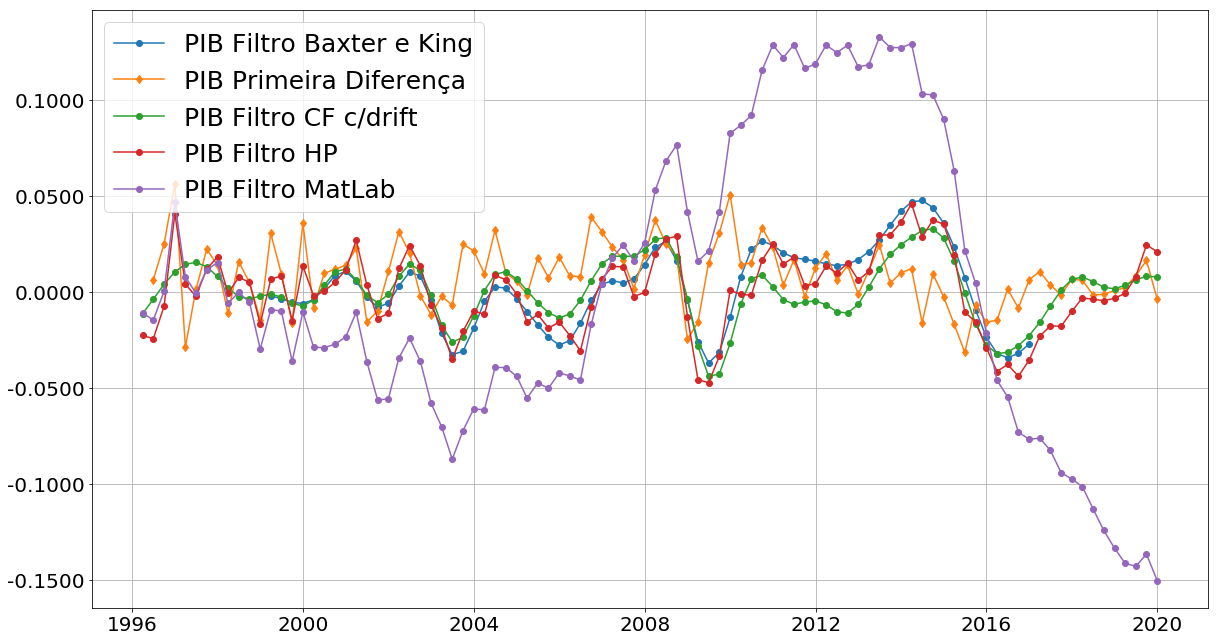

In [24]:
fmt = '{x:,.4f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.index,
        pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.values,
        '-o',
        label='PIB Filtro Baxter e King')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(pib_deflacionado_primeira_diferenca.index,
        pib_deflacionado_primeira_diferenca.values,
        '-d',
        label='PIB Primeira Diferença')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald asymmetric, random walk filter.
ax.plot(pib_cf_filter_cycle_cf_drift.index,
        pib_cf_filter_cycle_cf_drift.values,
        '-o',
        label='PIB Filtro CF c/drift')



# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald sem drift
#ax.plot(pib_cf_filter_cycle_cf_drift_s.index,
#        pib_cf_filter_cycle_cf_drift_s.values,
#        '-o',
#        label='PIB Filtro CF s/drift')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro HP.
ax.plot(pib_hp_filter_cycle.index,
        pib_hp_filter_cycle.values,
        '-o',
        label='PIB Filtro HP')

ax.plot(dataframe_pib_consumo_filtrados_matlab.index,
        dataframe_pib_consumo_filtrados_matlab['PIB_detrended'].values,
        '-o',
        label='PIB Filtro MatLab')

# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

## 4.1 Consumo Real Dessazonalizado 1996:T1-2016:T4

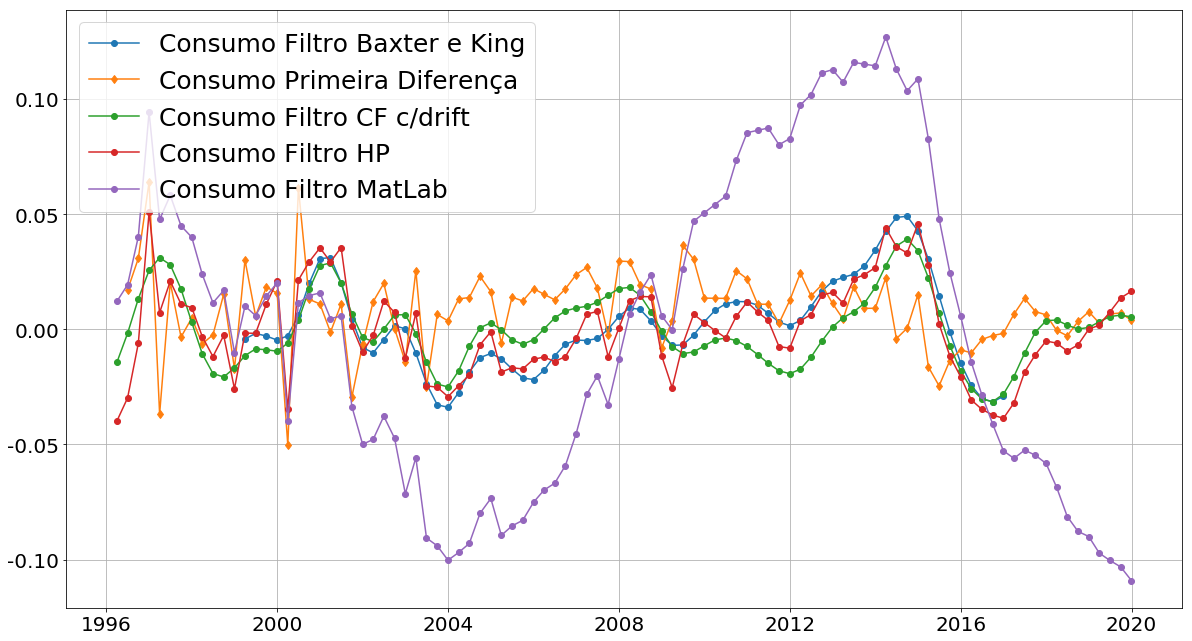

In [25]:
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(consumo_deflacionado_ipca_dessazonalizado_filtrado_bk.index,
        consumo_deflacionado_ipca_dessazonalizado_filtrado_bk.values,
        '-o',
        label='Consumo Filtro Baxter e King')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(consumo_deflacionado_primeira_diferenca.index,
        consumo_deflacionado_primeira_diferenca.values,
        '-d',
        label='Consumo Primeira Diferença')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald asymmetric, random walk filter.
ax.plot(consumo_cf_filter_cycle_cf_drift.index,
        consumo_cf_filter_cycle_cf_drift.values,
        '-o',
        label='Consumo Filtro CF c/drift')



# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald sem drift
#ax.plot(pib_cf_filter_cycle_cf_drift_s.index,
#        pib_cf_filter_cycle_cf_drift_s.values,
#        '-o',
#        label='PIB Filtro CF s/drift')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro HP.
ax.plot(consumo_hp_filter_cycle.index,
        consumo_hp_filter_cycle.values,
        '-o',
        label='Consumo Filtro HP')

ax.plot(dataframe_pib_consumo_filtrados_matlab.index,
        dataframe_pib_consumo_filtrados_matlab['Consumo_detrended'].values,
        '-o',
        label='Consumo Filtro MatLab')




# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Plot EMBI+ Trimestral, Média e Fim do Periodo

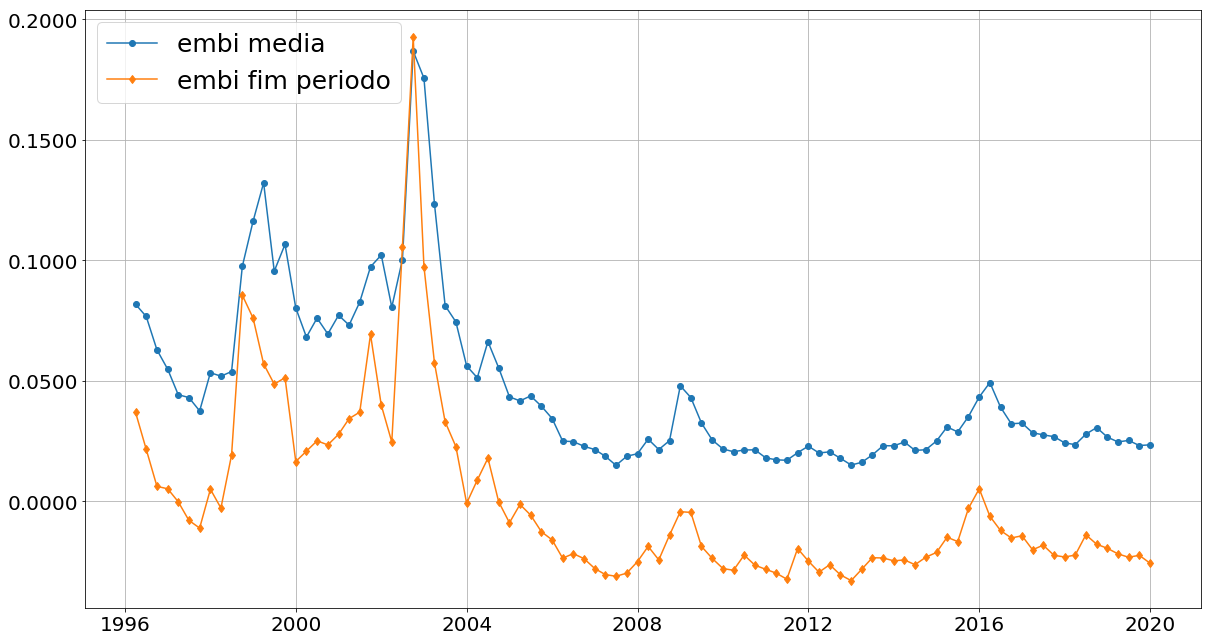

In [26]:
fmt = '{x:,.4f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(embi_media.index,
        embi_media.values,
        '-o',
        label='embi media')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(embi_fim_periodo.index,
        embi_fim_periodo.values,
        '-d',
        label='embi fim periodo')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Plot Juros Americanos 10 Anos Trimestral, Média e Fim do Periodo

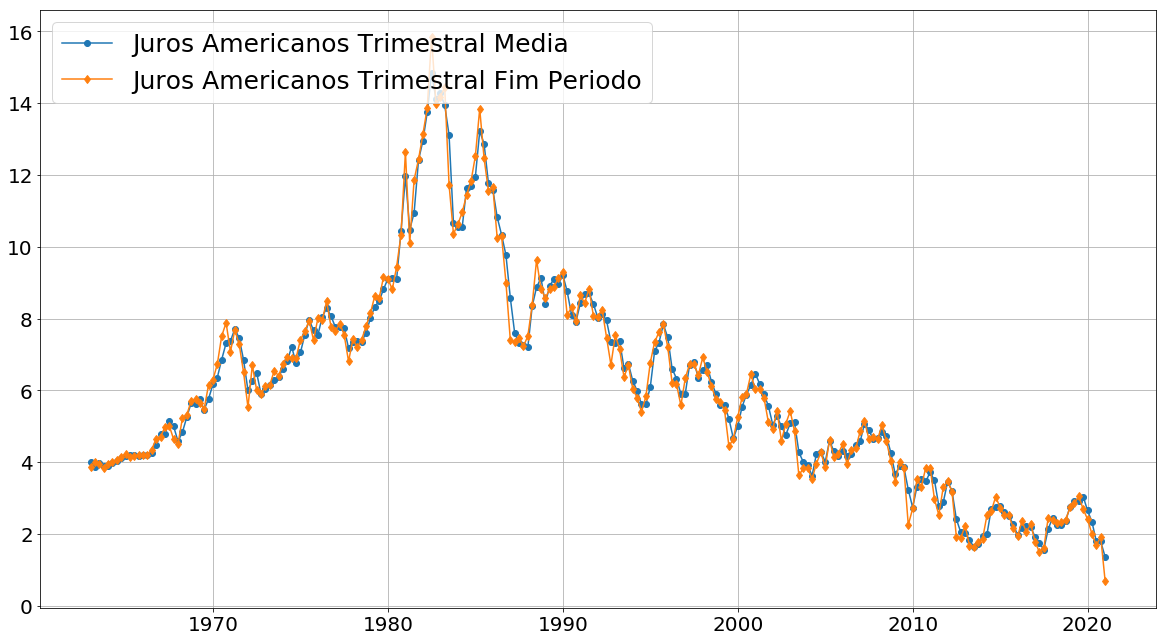

In [27]:
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(taxa_juros_americanos_media.index,
        taxa_juros_americanos_media.values,
        '-o',
        label='Juros Americanos Trimestral Media')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(taxa_juros_americanos_fim_periodo.index,
        taxa_juros_americanos_fim_periodo.values,
        '-d',
        label='Juros Americanos Trimestral Fim Periodo')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Media da Taxa dos Juros Americanos

In [28]:
taxa_media_juros_americano = dataframe_juros_americanos['DGS10 fim periodo trimestral'].mean()/100

# Tabela de Correlações

In [29]:
correlation_dataframe = pd.concat([correlation_dataframe,
                                   dataframe_pib_consumo_filtrados_matlab], axis=1, sort=False)

In [30]:
correlation_dataframe.describe()

,EMBI Fim de Período,Saldo BC/PIB %,PIB_detrended,Consumo_detrended
count,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01
mean,-1.156482e-18,3.794708e-19,-2.201711e-14,1.448870e-14
std,3.681749e-02,1.957810e-02,7.672852e-02,6.826785e-02
min,-3.285833e-02,-2.821997e-02,-1.502723e-01,-1.091724e-01
25%,-2.358333e-02,-1.612991e-02,-5.126961e-02,-5.662148e-02
50%,-1.455833e-02,-3.821255e-03,-1.060169e-02,5.885949e-03
75%,1.689167e-02,1.069658e-02,5.536233e-02,4.872257e-02
max,1.926417e-01,4.217824e-02,1.325981e-01,1.269774e-01


In [31]:
correlation_dataframe.corr(method='pearson')

,EMBI Fim de Período,Saldo BC/PIB %,PIB_detrended,Consumo_detrended
EMBI Fim de Período,1.000000,-0.040132,-0.293608,-0.229853
Saldo BC/PIB %,-0.040132,1.000000,-0.430528,-0.715521
PIB_detrended,-0.293608,-0.430528,1.000000,0.906366
Consumo_detrended,-0.229853,-0.715521,0.906366,1.000000


#  Valores Reais (Parametros para o erro quadratico Medio)

In [32]:
tabela_real = correlation_dataframe.corr(method='pearson')

In [33]:
corrRealSpreadBC = round(tabela_real['EMBI Fim de Período'][1],4)
corrRealSpreadPIB = round(tabela_real['EMBI Fim de Período'][2],4)
corrRealPibBC = round(tabela_real['Saldo BC/PIB %'][2],4)

### Desvio Padrão

In [34]:
correlation_dataframe.std()

EMBI Fim de Período    0.036817
Saldo BC/PIB %         0.019578
PIB_detrended          0.076729
Consumo_detrended      0.068268
dtype: float64

## 5) AR (1)

In [35]:
import statsmodels.tsa.ar_model as ar_model

diretorio = os.path.dirname(os.getcwd())
local_arquivo = os.path.join(diretorio,
                             'notebook',
                             'Dados_filtrados.xlsx')

#abrindo o arquivo em dataframe no pandas
dataframe_pib_consumo_filtrados_matlab = pd.read_excel(local_arquivo)




regressao  = ar_model.AR(dataframe_pib_consumo_filtrados_matlab['PIB_filtrado']).fit(maxlag=1,trend='nc')

print({'coef':regressao.params[0],
       'Std': regressao.bse[0]})

coef_regressao_ar1 = regressao.params[0]
std_regressao_ar1 = regressao.bse[0]

{'coef': 0.8737901483366254, 'Std': 0.051294009240897546}


/home/frederico/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Future

In [36]:
import statsmodels.tsa.statespace.sarimax as sarimax

regressao  = sarimax.SARIMAX(dataframe_pib_consumo_filtrados_matlab['PIB_filtrado'],order=(1,0,0),trend='n').fit()


In [37]:
regressao.params[0]

0.8737900764342168

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

## 5.1) Teste Raiz Unitária

A second set of facts about emerging markets relates to the behavior of the interest rates at which these economies borrow from the rest of the world and their current accounts.
Interest rates and the current account are strongly countercyclical and positively correlated to each other. That is, emerging markets tend to borrow more in good times and at lower interest rates as compared to slumps. These features contrast with those observed in developed small open economies. 

# Modelo Arellano

#  Calibração (variaveis  "ajustaveis" beta, gama, theta)

In [38]:
import sys
sys.path.append('..')

from python.arellano_model import Arellano_Economy
    
Economia_Arellano = Arellano_Economy(β = .9599,        # time discount rate
                                     γ = 2,          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = 0.289,       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)

Running iteration 25 with dist of 0.39404819245864786
Running iteration 50 with dist of 0.13807341284138985
Running iteration 75 with dist of 0.049588962575512596
Running iteration 100 with dist of 0.017824685413181385
Running iteration 125 with dist of 0.0064072433871018575
Running iteration 150 with dist of 0.0023031435007254686
Running iteration 175 with dist of 0.0008278864784898587
Running iteration 200 with dist of 0.0002975915403773399
Running iteration 225 with dist of 0.00010697206345611221
Running iteration 250 with dist of 3.845210904884766e-05
Running iteration 275 with dist of 1.3821970362926095e-05
Running iteration 300 with dist of 4.9684365777125095e-06
Running iteration 325 with dist of 1.7859510244022658e-06
Running iteration 350 with dist of 6.419768148191451e-07
Running iteration 375 with dist of 2.3076458788295895e-07
Running iteration 400 with dist of 8.295049980233671e-08
Running iteration 425 with dist of 2.981734681384296e-08
Running iteration 450 with dist of 

## Preço Par

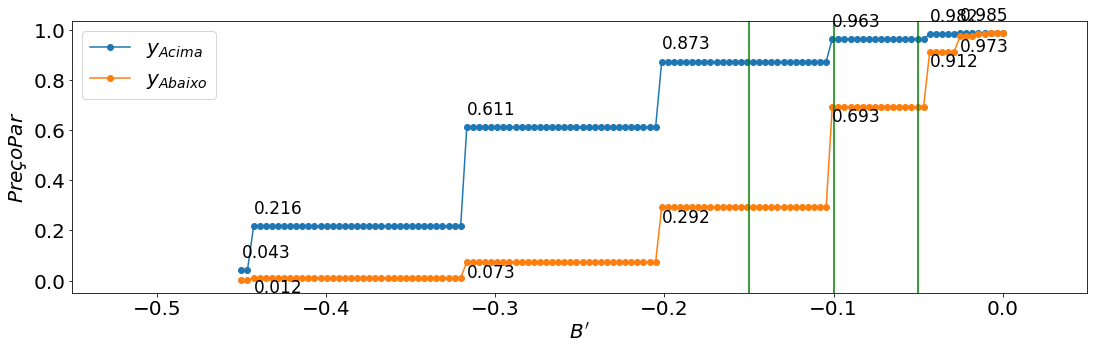

In [39]:
import importlib

import python.arellano_graficos

importlib.reload(python.arellano_graficos)


python.arellano_graficos.graficoPreco(Economia_Arellano,'PreçoPar')

## Juros

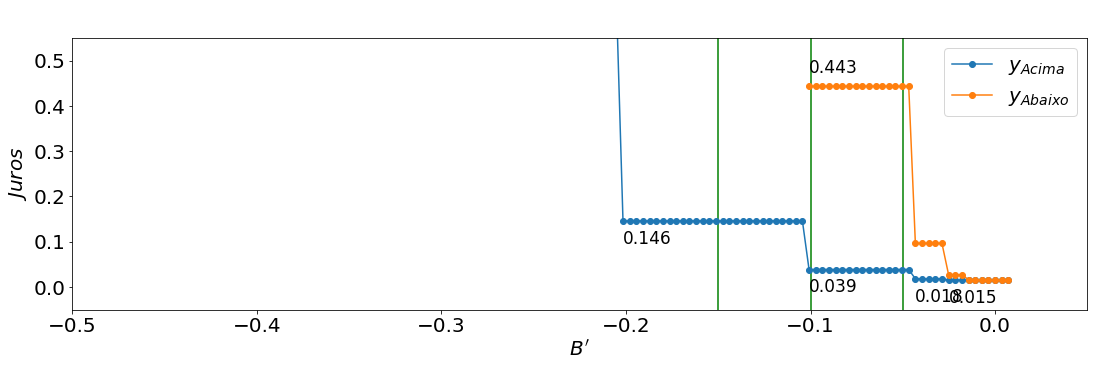

In [40]:
python.arellano_graficos.graficoJuros(Economia_Arellano,'Juros')

# Função Valor Otimo Default

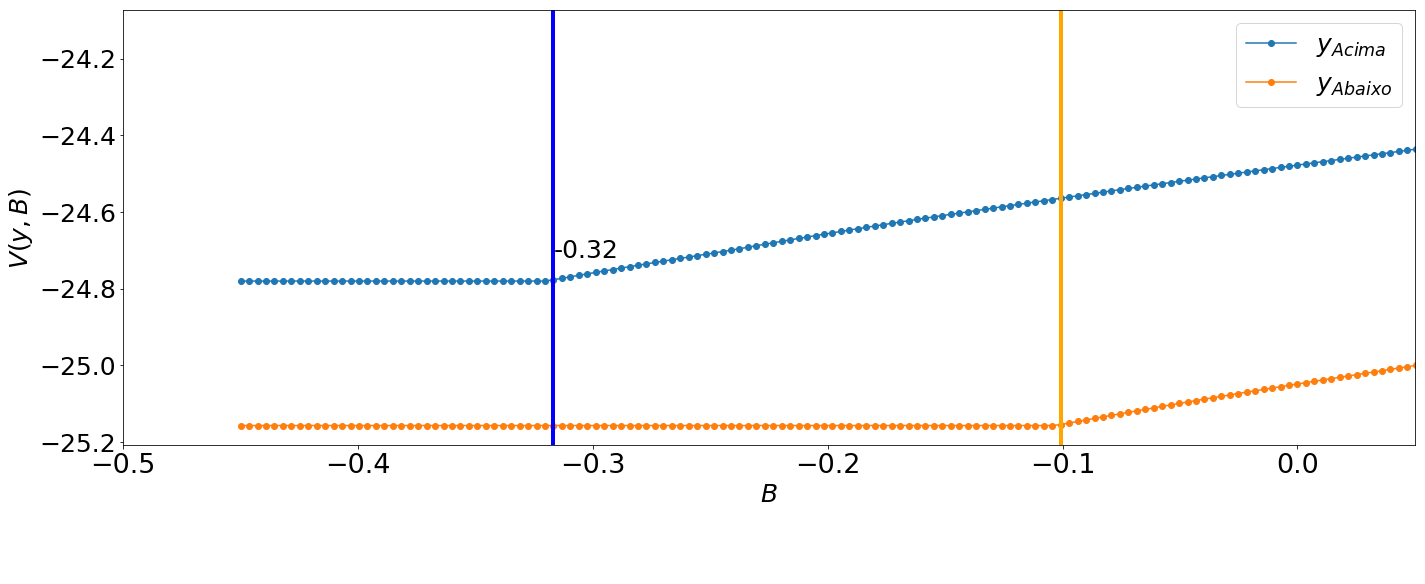

In [41]:
python.arellano_graficos.graficoFuncaoValor(Economia_Arellano,'Funcao Valor')

## Simulação do Ciclo

# Valores Simulados (Parametros para o erro quadratico Medio)

In [42]:
from python.arellano_graficos import simulacao

importlib.reload(python.arellano_graficos)

<module 'python.arellano_graficos' from '../python/arellano_graficos.py'>

In [43]:
dados_1 = simulacao(Economia_Arellano)['simulacao_1']
pd.DataFrame(simulacao(Economia_Arellano)['simulacao_1'])

,dados simulados,média(x),desvio padrão(x),"corr(x,y)","corr(x,r-spread)"
0,Spread Taxa de Juros,2.596987,1.427128,-0.43056,
1,Balança Comercial,0.615990,5.392241,-0.298881,-0.334657
2,Consumo,0.986762,0.104623,0.696704,-0.314065
3,Produto,0.995473,0.084738,,-0.43056


In [44]:
from python.arellano_graficos import plot_simulacao

importlib.reload(python.arellano_graficos)

<module 'python.arellano_graficos' from '../python/arellano_graficos.py'>

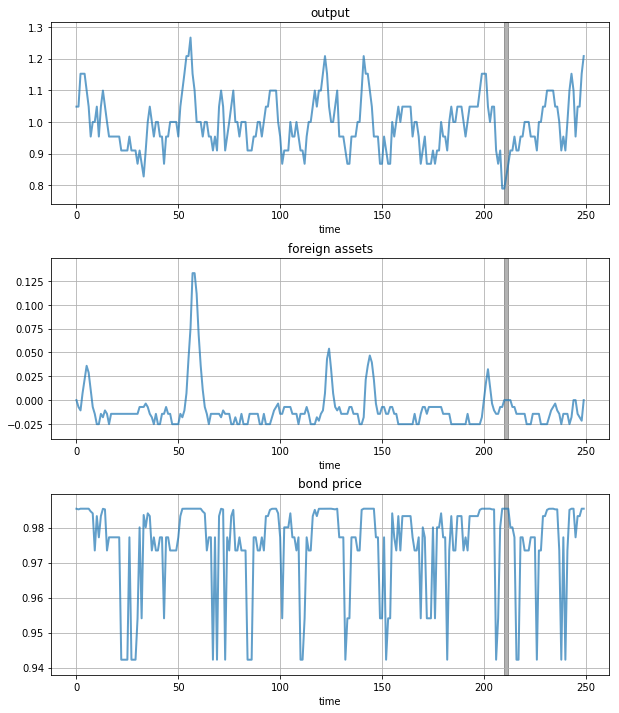

In [45]:
plot_simulacao(Economia_Arellano)

In [46]:
dados_1['corr(x,r-spread)']

['', -0.233245, -0.29438, -0.335937]

In [47]:
pd.DataFrame(simulacao(Economia_Arellano)['simulacao_2'])

,variavel,valor
0,mean dívida externa,0.014875
1,mean trade balance,0.426720
2,mean default Probability,0.000000


In [43]:
from scipy.optimize import minimize

In [55]:
def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(β = x[0],        # time discount rate
                                     γ = 2.5,          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = 0.289,       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    valorObjetivo = ((corrRealPibBC - corrSimuPibBC)**2 + (corrRealSpreadBC - corrSimuSpreadBC)**2 + (corrRealSpreadPIB - corrSimuSpreadPIB)**2)**(1/2)
    return valorObjetivo

In [56]:
import numpy as np
espaco = np.arange(0.7, 0.999999999, 0.01)




In [57]:
resultado_funcao = []
for parametro in espaco:
    resultado_funcao.append(funcao_otimizar([parametro]))

[0.7]
Running iteration 25 with dist of 0.00593777165851872
Running iteration 50 with dist of 1.5458654267774818e-07
[0.71]
Running iteration 25 with dist of 0.00603110047579225
Running iteration 50 with dist of 2.1107194125846718e-07
[0.72]
Running iteration 25 with dist of 0.006282784380879924
Running iteration 50 with dist of 3.3499412355197933e-07
[0.73]
Running iteration 25 with dist of 0.004432540476424052
Running iteration 50 with dist of 5.166540866241576e-07
[0.74]
Running iteration 25 with dist of 0.004761546431270247
Running iteration 50 with dist of 8.567618747790107e-07
[0.75]
Running iteration 25 with dist of 0.005271731709279415
Running iteration 50 with dist of 1.4290060312838193e-06
[0.76]
Running iteration 25 with dist of 0.005777548508413055
Running iteration 50 with dist of 2.436439095809817e-06
[0.77]
Running iteration 25 with dist of 0.006269260333255033
Running iteration 50 with dist of 4.067138153374117e-06
[0.78]
Running iteration 25 with dist of 0.006853714936

Running iteration 100 with dist of 0.033712394338156315
Running iteration 125 with dist of 0.015742803794726257
Running iteration 150 with dist of 0.0073514906524323465
Running iteration 175 with dist of 0.003432960172432331
Running iteration 200 with dist of 0.0016031055645555625
Running iteration 225 with dist of 0.0007486097485092102
Running iteration 250 with dist of 0.00034958181667121835
Running iteration 275 with dist of 0.00016324586581362155
Running iteration 300 with dist of 7.623169008041941e-05
Running iteration 325 with dist of 3.559827101540236e-05
Running iteration 350 with dist of 1.6623492125944495e-05
Running iteration 375 with dist of 7.762750342976688e-06
Running iteration 400 with dist of 3.625008062613233e-06
Running iteration 425 with dist of 1.6927870838401304e-06
Running iteration 450 with dist of 7.904887553422668e-07
Running iteration 475 with dist of 3.69138266620439e-07
Running iteration 500 with dist of 1.723782396823026e-07
Running iteration 525 with dist

No handles with labels found to put in legend.


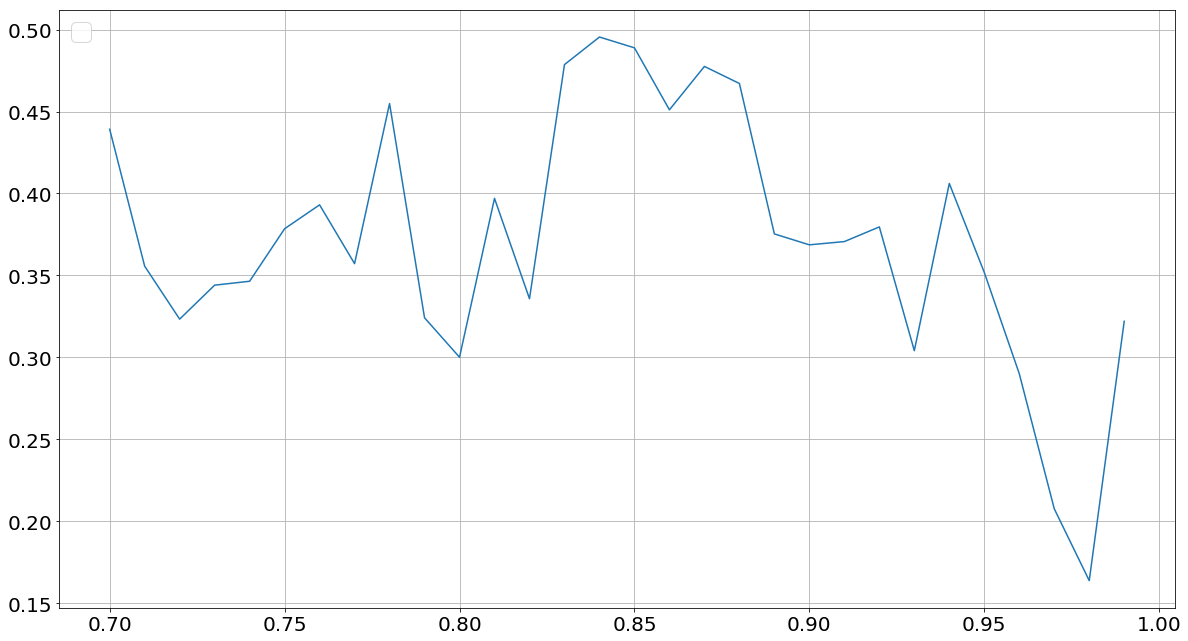

In [60]:
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(espaco,resultado_funcao)

# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Teste Coeficiente de risco

In [61]:
def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(β = 0.98,        # time discount rate
                                     γ = x[0],          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = 0.289,       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    valorObjetivo = ((corrRealPibBC - corrSimuPibBC)**2 + (corrRealSpreadBC - corrSimuSpreadBC)**2 + (corrRealSpreadPIB - corrSimuSpreadPIB)**2)**(1/2)
    return valorObjetivo

In [62]:
import numpy as np
espaco_coef_risco = np.arange(2.5, 4.5, 0.1)

In [63]:
resultado_funcao = []
for parametro in espaco_coef_risco:
    resultado_funcao.append(funcao_otimizar([parametro]))

[2.5]
Running iteration 25 with dist of 0.4376564829848917
Running iteration 50 with dist of 0.2535560098952949
Running iteration 75 with dist of 0.15274976623403802
Running iteration 100 with dist of 0.09217303614342853
Running iteration 125 with dist of 0.05562304491587611
Running iteration 150 with dist of 0.03356654299229689
Running iteration 175 with dist of 0.02025622473844635
Running iteration 200 with dist of 0.012223917186936717
Running iteration 225 with dist of 0.007376702882055497
Running iteration 250 with dist of 0.004451580011384237
Running iteration 275 with dist of 0.002686371528668019
Running iteration 300 with dist of 0.0016211304686493122
Running iteration 325 with dist of 0.000978295060214407
Running iteration 350 with dist of 0.000590366564168221
Running iteration 375 with dist of 0.00035626539914090927
Running iteration 400 with dist of 0.00021499360283172564
Running iteration 425 with dist of 0.00012974105644758538
Running iteration 450 with dist of 7.8294151592

Running iteration 125 with dist of 0.04429997398328567
Running iteration 150 with dist of 0.026733468654835946
Running iteration 175 with dist of 0.016132705371379785
Running iteration 200 with dist of 0.00973551868615985
Running iteration 225 with dist of 0.005875042153181909
Running iteration 250 with dist of 0.0035453807254199887
Running iteration 275 with dist of 0.0021395122214329376
Running iteration 300 with dist of 0.0012911201645771087
Running iteration 325 with dist of 0.0007791454812320353
Running iteration 350 with dist of 0.0004701868172993784
Running iteration 375 with dist of 0.0002837411606577689
Running iteration 400 with dist of 0.00017122778285028062
Running iteration 425 with dist of 0.00010332992771822092
Running iteration 450 with dist of 6.235596691439582e-05
Running iteration 475 with dist of 3.76296267319276e-05
Running iteration 500 with dist of 2.2708152535244608e-05
Running iteration 525 with dist of 1.3703569138101557e-05
Running iteration 550 with dist of 

Running iteration 225 with dist of 0.004902091506117756
Running iteration 250 with dist of 0.0029582393261016193
Running iteration 275 with dist of 0.0017851930955536943
Running iteration 300 with dist of 0.0010773010690172669
Running iteration 325 with dist of 0.0006501131985139352
Running iteration 350 with dist of 0.000392320385675049
Running iteration 375 with dist of 0.00023675151553348428
Running iteration 400 with dist of 0.0001428711893538548
Running iteration 425 with dist of 8.621772368400116e-05
Running iteration 450 with dist of 5.2029355330773797e-05
Running iteration 475 with dist of 3.139788086059525e-05
Running iteration 500 with dist of 1.894751370201675e-05
Running iteration 525 with dist of 1.143415624227373e-05
Running iteration 550 with dist of 6.900110012253435e-06
Running iteration 575 with dist of 4.16397303837357e-06
Running iteration 600 with dist of 2.5128108660510406e-06
Running iteration 625 with dist of 1.5163927393757604e-06
Running iteration 650 with dis

KeyboardInterrupt: 

In [ ]:
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(espaco_coef_risco, resultado_funcao)

# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Teste Prob de Reentrada

In [ ]:
def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(β = 0.98,        # time discount rate
                                     γ = 2.75,          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = x[0],       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    valorObjetivo = ((corrRealPibBC - corrSimuPibBC)**2 + (corrRealSpreadBC - corrSimuSpreadBC)**2 + (corrRealSpreadPIB - corrSimuSpreadPIB)**2)**(1/2)
    return valorObjetivo

In [ ]:
import numpy as np
espaco_prob_reentrada = np.arange(0, 1, 0.01)

In [ ]:
resultado_funcao = []
for parametro in espaco_prob_reentrada:
    resultado_funcao.append(funcao_otimizar([parametro]))

In [ ]:
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(espaco_prob_reentrada, resultado_funcao)

# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Otimização

In [ ]:
def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(β = x[0],        # time discount rate
                                     γ = x[1],          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = x[2],       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    valorObjetivo = ((corrRealPibBC - corrSimuPibBC)**2 + (corrRealSpreadBC - corrSimuSpreadBC)**2 + (corrRealSpreadPIB - corrSimuSpreadPIB)**2)**(1/2)
    return valorObjetivo

In [66]:
bnds = ((0.1, 0.999), (1.5, 3.5), (0,1))
res = minimize(funcao_otimizar,[0.90,2.85,0.289],bounds=bnds)

[0.9   2.85  0.289]
Running iteration 25 with dist of 6.166701107076051
Running iteration 50 with dist of 3.7134342062188352
Running iteration 75 with dist of 2.240756459398199
Running iteration 100 with dist of 1.3522139613796753
Running iteration 125 with dist of 0.8160133597227173
Running iteration 150 with dist of 0.49243528010850923
Running iteration 175 with dist of 0.2971673232130456
Running iteration 200 with dist of 0.17932999840155617
Running iteration 225 with dist of 0.10821932902672415
Running iteration 250 with dist of 0.06530654814810077
Running iteration 275 with dist of 0.039410198431085064
Running iteration 300 with dist of 0.023782664746988758
Running iteration 325 with dist of 0.01435199935502851
Running iteration 350 with dist of 0.008660925412698361
Running iteration 375 with dist of 0.005226563013934538
Running iteration 400 with dist of 0.0031540464369754773
Running iteration 425 with dist of 0.0019033557809393642
Running iteration 450 with dist of 0.00114860808

Running iteration 550 with dist of 0.00015232789399988178
Running iteration 575 with dist of 9.192451153694492e-05
Running iteration 600 with dist of 5.547320063215011e-05
Running iteration 625 with dist of 3.347612016568746e-05
Running iteration 650 with dist of 2.0201657889629132e-05
Running iteration 675 with dist of 1.219098822957676e-05
Running iteration 700 with dist of 7.356831474680803e-06
Running iteration 725 with dist of 4.439588451532472e-06
Running iteration 750 with dist of 2.679135150174261e-06
Running iteration 775 with dist of 1.616763654510578e-06
Running iteration 800 with dist of 9.756599865795579e-07
Running iteration 825 with dist of 5.887764586987032e-07
Running iteration 850 with dist of 3.5530592867871746e-07
Running iteration 875 with dist of 2.1441468334160163e-07
Running iteration 900 with dist of 1.2939182170157437e-07
Running iteration 925 with dist of 7.808347390891868e-08
Running iteration 950 with dist of 4.712074996859883e-08
Running iteration 975 with

In [65]:
res

      fun: 0.21122381494519027
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0.98 , 2.85 , 0.289])

# Superficie

In [48]:
def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(β = x[0],        # time discount rate
                                     γ = x[1],          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = coef_regressao_ar1 ,  # persistence in output
                                     η = std_regressao_ar1,   # st dev of output shock
                                     θ = 0.289,       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    valorObjetivo = ((corrRealPibBC - corrSimuPibBC)**2 + (corrRealSpreadBC - corrSimuSpreadBC)**2 + (corrRealSpreadPIB - corrSimuSpreadPIB)**2)**(1/2)
    return valorObjetivo

In [127]:
import numpy as np
betas = np.arange(0.7, 0.999999999, 0.01)
gamas = np.arange(2.5, 4.5, 0.1)

func_result = []
betas, gamas = np.meshgrid(betas, gamas)


for beta, gama in zip(np.ravel(betas),
                      np.ravel(gamas)):
    
    func_result.append(funcao_otimizar([beta,gama]))
func_result = np.array(func_result)

func_result = func_result.reshape(betas.shape)

[0.7, 2.5]
Running iteration 25 with dist of 0.00593777165851872
Running iteration 50 with dist of 1.5458654267774818e-07
[0.71, 2.5]
Running iteration 25 with dist of 0.00603110047579225
Running iteration 50 with dist of 2.1107194125846718e-07
[0.72, 2.5]
Running iteration 25 with dist of 0.006282784380879924
Running iteration 50 with dist of 3.3499412355197933e-07
[0.73, 2.5]
Running iteration 25 with dist of 0.004432540476424052
Running iteration 50 with dist of 5.166540866241576e-07
[0.74, 2.5]
Running iteration 25 with dist of 0.004761546431270247
Running iteration 50 with dist of 8.567618747790107e-07
[0.75, 2.5]
Running iteration 25 with dist of 0.005271731709279415
Running iteration 50 with dist of 1.4290060312838193e-06
[0.76, 2.5]
Running iteration 25 with dist of 0.005777548508413055
Running iteration 50 with dist of 2.436439095809817e-06
[0.77, 2.5]
Running iteration 25 with dist of 0.006269260333255033
Running iteration 50 with dist of 4.067138153374117e-06
[0.78, 2.5]
Run

Running iteration 25 with dist of 0.345492970161942
Running iteration 50 with dist of 0.15484961576376932
Running iteration 75 with dist of 0.07219733377825222
Running iteration 100 with dist of 0.033712394338156315
Running iteration 125 with dist of 0.015742803794726257
Running iteration 150 with dist of 0.0073514906524323465
Running iteration 175 with dist of 0.003432960172432331
Running iteration 200 with dist of 0.0016031055645555625
Running iteration 225 with dist of 0.0007486097485092102
Running iteration 250 with dist of 0.00034958181667121835
Running iteration 275 with dist of 0.00016324586581362155
Running iteration 300 with dist of 7.623169008041941e-05
Running iteration 325 with dist of 3.559827101540236e-05
Running iteration 350 with dist of 1.6623492125944495e-05
Running iteration 375 with dist of 7.762750342976688e-06
Running iteration 400 with dist of 3.625008062613233e-06
Running iteration 425 with dist of 1.6927870838401304e-06
Running iteration 450 with dist of 7.9048

Running iteration 50 with dist of 2.3773230068968587e-06
[0.77, 2.6]
Running iteration 25 with dist of 0.006427972340528498
Running iteration 50 with dist of 4.0197026862642815e-06
[0.78, 2.6]
Running iteration 25 with dist of 0.00711256295043583
Running iteration 50 with dist of 6.756761637305431e-06
Running iteration 75 with dist of 1.3273349530606993e-08
[0.79, 2.6]
Running iteration 25 with dist of 0.00784126167123489
Running iteration 50 with dist of 1.1519739448573318e-05
Running iteration 75 with dist of 3.1257669341755445e-08
[0.8, 2.6]
Running iteration 25 with dist of 0.00808555291890034
Running iteration 50 with dist of 1.9464330224039372e-05
Running iteration 75 with dist of 7.258720380320938e-08
[0.81, 2.6]
Running iteration 25 with dist of 0.009391066533851244
Running iteration 50 with dist of 3.276084480496877e-05
Running iteration 75 with dist of 1.6694182303211846e-07
[0.8200000000000001, 2.6]
Running iteration 25 with dist of 0.011240407171067446
Running iteration 50 

Running iteration 400 with dist of 3.4078936188564057e-06
Running iteration 425 with dist of 1.5914001281203127e-06
Running iteration 450 with dist of 7.431436124250013e-07
Running iteration 475 with dist of 3.470292782026263e-07
Running iteration 500 with dist of 1.6205390451773383e-07
Running iteration 525 with dist of 7.567508575334614e-08
Running iteration 550 with dist of 3.5338359793968266e-08
Running iteration 575 with dist of 1.6502127664352884e-08
[0.9800000000000002, 2.6]
Running iteration 25 with dist of 0.41261096855531676
Running iteration 50 with dist of 0.23823692783462036
Running iteration 75 with dist of 0.14349899910180852
Running iteration 100 with dist of 0.0865903629237188
Running iteration 125 with dist of 0.05225409488723187
Running iteration 150 with dist of 0.03153350039546865
Running iteration 175 with dist of 0.019029355235488765
Running iteration 200 with dist of 0.011483544713847493
Running iteration 225 with dist of 0.006929914207624677
Running iteration 2

Running iteration 75 with dist of 1.63126653518475e-07
[0.8200000000000001, 2.7]
Running iteration 25 with dist of 0.011085924959406412
Running iteration 50 with dist of 5.442463609117709e-05
Running iteration 75 with dist of 3.7718438328226966e-07
[0.8300000000000001, 2.7]
Running iteration 25 with dist of 0.013339927449457
Running iteration 50 with dist of 9.356964369811038e-05
Running iteration 75 with dist of 8.790439931516403e-07
Running iteration 100 with dist of 8.333500112200909e-09
[0.8400000000000001, 2.7]
Running iteration 25 with dist of 0.015914369280009666
Running iteration 50 with dist of 0.00015957081619699665
Running iteration 75 with dist of 2.025668617733345e-06
Running iteration 100 with dist of 2.59082657549925e-08
[0.8500000000000001, 2.7]
Running iteration 25 with dist of 0.019505402922115778
Running iteration 50 with dist of 0.0002723262846133778
Running iteration 75 with dist of 4.652670691385197e-06
Running iteration 100 with dist of 7.99981272336936e-08
[0.86

Running iteration 200 with dist of 0.010831321703584251
Running iteration 225 with dist of 0.006536320624974223
Running iteration 250 with dist of 0.003944438959720742
Running iteration 275 with dist of 0.002380329790959479
Running iteration 300 with dist of 0.001436445074098458
Running iteration 325 with dist of 0.0008668439384962312
Running iteration 350 with dist of 0.0005231097431206422
Running iteration 375 with dist of 0.0003156782797830715
Running iteration 400 with dist of 0.00019050070782355988
Running iteration 425 with dist of 0.00011496045817693812
Running iteration 450 with dist of 6.937458184097522e-05
Running iteration 475 with dist of 4.186511330317444e-05
Running iteration 500 with dist of 2.5264119294376997e-05
Running iteration 525 with dist of 1.524600493496564e-05
Running iteration 550 with dist of 9.200426262623296e-06
Running iteration 575 with dist of 5.552132762431938e-06
Running iteration 600 with dist of 3.3505163088420886e-06
Running iteration 625 with dist 

Running iteration 100 with dist of 2.4954026400791918e-08
[0.8500000000000001, 2.8000000000000003]
Running iteration 25 with dist of 0.019068755292691364
Running iteration 50 with dist of 0.0002621310739874261
Running iteration 75 with dist of 4.476495266025893e-06
Running iteration 100 with dist of 7.696781345600812e-08
[0.8600000000000001, 2.8000000000000003]
Running iteration 25 with dist of 0.023101116220732187
Running iteration 50 with dist of 0.00044596438601907096
Running iteration 75 with dist of 1.0215485048092887e-05
Running iteration 100 with dist of 2.353078549788279e-07
[0.8700000000000001, 2.8000000000000003]
Running iteration 25 with dist of 0.028760884909409867
Running iteration 50 with dist of 0.0007612054449284145
Running iteration 75 with dist of 2.329166343972844e-05
Running iteration 100 with dist of 7.163171540369717e-07
Running iteration 125 with dist of 2.2033530555631842e-08
[0.8800000000000001, 2.8000000000000003]
Running iteration 25 with dist of 0.0359205285

Running iteration 425 with dist of 0.00010881879045143705
Running iteration 450 with dist of 6.566830198195817e-05
Running iteration 475 with dist of 3.9628504115540863e-05
Running iteration 500 with dist of 2.3914404536640177e-05
Running iteration 525 with dist of 1.4431499682387994e-05
Running iteration 550 with dist of 8.708901063414487e-06
Running iteration 575 with dist of 5.255514633262237e-06
Running iteration 600 with dist of 3.171517722222461e-06
Running iteration 625 with dist of 1.9138990943190493e-06
Running iteration 650 with dist of 1.1549706115943081e-06
Running iteration 675 with dist of 6.969840313786335e-07
Running iteration 700 with dist of 4.20605289264131e-07
Running iteration 725 with dist of 2.538204597613003e-07
Running iteration 750 with dist of 1.5317170465323215e-07
Running iteration 775 with dist of 9.243373000344945e-08
Running iteration 800 with dist of 5.5780503771529766e-08
Running iteration 825 with dist of 3.366157486084376e-08
Running iteration 850 wi

Running iteration 100 with dist of 2.270324479525243e-07
[0.8700000000000001, 2.9000000000000004]
Running iteration 25 with dist of 0.02794442725336932
Running iteration 50 with dist of 0.0007305862893263182
Running iteration 75 with dist of 2.235109133685853e-05
Running iteration 100 with dist of 6.873863682699266e-07
Running iteration 125 with dist of 2.1143631734332757e-08
[0.8800000000000001, 2.9000000000000004]
Running iteration 25 with dist of 0.03478613789880658
Running iteration 50 with dist of 0.0012399677138130727
Running iteration 75 with dist of 5.0514056000317e-05
Running iteration 100 with dist of 2.0673283014360777e-06
Running iteration 125 with dist of 8.462016776178416e-08
[0.8900000000000001, 2.9000000000000004]
Running iteration 25 with dist of 0.04338267819950126
Running iteration 50 with dist of 0.0020927007650204388
Running iteration 75 with dist of 0.00011318488992362319
Running iteration 100 with dist of 6.144447254996521e-06
Running iteration 125 with dist of 3

Running iteration 675 with dist of 6.618278831638236e-07
Running iteration 700 with dist of 3.993897941256819e-07
Running iteration 725 with dist of 2.4101765916384466e-07
Running iteration 750 with dist of 1.4544566084850885e-07
Running iteration 775 with dist of 8.777133686521665e-08
Running iteration 800 with dist of 5.2966917962748994e-08
Running iteration 825 with dist of 3.196366904489878e-08
Running iteration 850 with dist of 1.928895443370493e-08
Running iteration 875 with dist of 1.1640207020491289e-08
[0.9900000000000002, 2.9000000000000004]
Running iteration 25 with dist of 0.4464623797672065
Running iteration 50 with dist of 0.3282041215763769
Running iteration 75 with dist of 0.2546452936631596
Running iteration 100 with dist of 0.19804970974024627
Running iteration 125 with dist of 0.1540467692831129
Running iteration 150 with dist of 0.11982085318883406
Running iteration 175 with dist of 0.09319921852623025
Running iteration 200 with dist of 0.07249234283868589
Running i

Running iteration 125 with dist of 8.132515549874597e-08
[0.8900000000000001, 3.0000000000000004]
Running iteration 25 with dist of 0.04226306692147119
Running iteration 50 with dist of 0.002016355738565956
Running iteration 75 with dist of 0.00010898733139974581
Running iteration 100 with dist of 5.916435821262667e-06
Running iteration 125 with dist of 3.2122405713153057e-07
Running iteration 150 with dist of 1.744047217755451e-08
[0.9000000000000001, 3.0000000000000004]
Running iteration 25 with dist of 0.052677554941311655
Running iteration 50 with dist of 0.0033847805653071106
Running iteration 75 with dist of 0.00024212885438679166
Running iteration 100 with dist of 1.7380305185277223e-05
Running iteration 125 with dist of 1.2477235076246984e-06
Running iteration 150 with dist of 8.957381059104819e-08
[0.9100000000000001, 3.0000000000000004]
Running iteration 25 with dist of 0.06632356649529925
Running iteration 50 with dist of 0.0056857429785726055
Running iteration 75 with dist 

Running iteration 75 with dist of 0.24233840665235817
Running iteration 100 with dist of 0.18847671935296262
Running iteration 125 with dist of 0.14660068063457032
Running iteration 150 with dist of 0.11402912605976212
Running iteration 175 with dist of 0.0886942894484335
Running iteration 200 with dist of 0.06898831277915463
Running iteration 225 with dist of 0.05366058322826461
Running iteration 250 with dist of 0.041738347792772856
Running iteration 275 with dist of 0.032464978419241675
Running iteration 300 with dist of 0.025251953646929337
Running iteration 325 with dist of 0.01964150891314631
Running iteration 350 with dist of 0.015277585163481433
Running iteration 375 with dist of 0.0118832320602138
Running iteration 400 with dist of 0.009243031715136851
Running iteration 425 with dist of 0.007189427493649703
Running iteration 450 with dist of 0.005592090266418381
Running iteration 475 with dist of 0.004349647252915645
Running iteration 500 with dist of 0.0033832485391798173
Run

Running iteration 100 with dist of 1.6731422987525946e-05
Running iteration 125 with dist of 1.2011399883604668e-06
Running iteration 150 with dist of 8.622958791448809e-08
[0.9100000000000001, 3.1000000000000005]
Running iteration 25 with dist of 0.06417032473438233
Running iteration 50 with dist of 0.005467376589281869
Running iteration 75 with dist of 0.0005155395020786102
Running iteration 100 with dist of 4.878034124189412e-05
Running iteration 125 with dist of 4.616128226331284e-06
Running iteration 150 with dist of 4.368301596002766e-07
Running iteration 175 with dist of 4.133781139614712e-08
[0.9200000000000002, 3.1000000000000005]
Running iteration 25 with dist of 0.0807949579578402
Running iteration 50 with dist of 0.009134047175361815
Running iteration 75 with dist of 0.0011326763571570808
Running iteration 100 with dist of 0.0001408506268365528
Running iteration 125 with dist of 1.751672866667775e-05
Running iteration 150 with dist of 2.178455220658293e-06
Running iteration

Running iteration 350 with dist of 0.014576737390449068
Running iteration 375 with dist of 0.011338097692657811
Running iteration 400 with dist of 0.008819014560316418
Running iteration 425 with dist of 0.006859617893866243
Running iteration 450 with dist of 0.0053355573151776525
Running iteration 475 with dist of 0.004150110444051336
Running iteration 500 with dist of 0.0032280445472636643
Running iteration 525 with dist of 0.0025108419979531504
Running iteration 550 with dist of 0.0019529865360894405
Running iteration 575 with dist of 0.0015190746424025292
Running iteration 600 with dist of 0.00118156870338737
Running iteration 625 with dist of 0.00091904937510634
Running iteration 650 with dist of 0.0007148562343033404
Running iteration 675 with dist of 0.0005560304479601541
Running iteration 700 with dist of 0.0004324923589038576
Running iteration 725 with dist of 0.00033640179454152985
Running iteration 750 with dist of 0.00026166050114539985
Running iteration 775 with dist of 0.0

[0.9200000000000002, 3.2000000000000006]
Running iteration 25 with dist of 0.078218791494022
Running iteration 50 with dist of 0.008783564791825071
Running iteration 75 with dist of 0.0010890362346973603
Running iteration 100 with dist of 0.00013542314709269476
Running iteration 125 with dist of 1.684174313965059e-05
Running iteration 150 with dist of 2.094511124539622e-06
Running iteration 175 with dist of 2.604823858831651e-07
Running iteration 200 with dist of 3.239471091376345e-08
[0.9300000000000002, 3.2000000000000006]
Running iteration 25 with dist of 0.09843225371333197
Running iteration 50 with dist of 0.01462862264273923
Running iteration 75 with dist of 0.0023769412287002467
Running iteration 100 with dist of 0.0003873011764774503
Running iteration 125 with dist of 6.311332250064083e-05
Running iteration 150 with dist of 1.028477290532237e-05
Running iteration 175 with dist of 1.6759784173814296e-06
Running iteration 200 with dist of 2.731128585509168e-07
Running iteration 2

Running iteration 625 with dist of 0.0008789699017413
Running iteration 650 with dist of 0.0006836815638493476
Running iteration 675 with dist of 0.0005317821233958853
Running iteration 700 with dist of 0.00041363149413342626
Running iteration 725 with dist of 0.0003217314110699476
Running iteration 750 with dist of 0.0002502495635283708
Running iteration 775 with dist of 0.00019464945570035752
Running iteration 800 with dist of 0.0001514025042510525
Running iteration 825 with dist of 0.00011776410168096163
Running iteration 850 with dist of 9.159943366654488e-05
Running iteration 875 with dist of 7.124799602564735e-05
Running iteration 900 with dist of 5.5418213129598826e-05
Running iteration 925 with dist of 4.310546988506303e-05
Running iteration 950 with dist of 3.3528355181999814e-05
Running iteration 975 with dist of 2.6079070821083405e-05
Running iteration 1000 with dist of 2.02848583299442e-05
Running iteration 1025 with dist of 1.5777996090093893e-05
Running iteration 1050 wit

Running iteration 75 with dist of 0.0022881060763193517
Running iteration 100 with dist of 0.0003728249651526738
Running iteration 125 with dist of 6.0754319461509e-05
Running iteration 150 with dist of 9.900356236158814e-06
Running iteration 175 with dist of 1.613334925210097e-06
Running iteration 200 with dist of 2.629046456092965e-07
Running iteration 225 with dist of 4.284222754336042e-08
[0.9400000000000002, 3.3000000000000007]
Running iteration 25 with dist of 0.12002209171236089
Running iteration 50 with dist of 0.023323154000147284
Running iteration 75 with dist of 0.004951874406872392
Running iteration 100 with dist of 0.0010542023060136074
Running iteration 125 with dist of 0.00022444961254386442
Running iteration 150 with dist of 4.778759238810437e-05
Running iteration 175 with dist of 1.0174462822476471e-05
Running iteration 200 with dist of 2.1662462827976015e-06
Running iteration 225 with dist of 4.6121580155045194e-07
Running iteration 250 with dist of 9.819752655459979e

Running iteration 925 with dist of 4.131375866478493e-05
Running iteration 950 with dist of 3.2134723944921006e-05
Running iteration 975 with dist of 2.49950746677996e-05
Running iteration 1000 with dist of 1.9441702967526453e-05
Running iteration 1025 with dist of 1.5122171838299892e-05
Running iteration 1050 with dist of 1.1762348265165201e-05
Running iteration 1075 with dist of 9.149005720132664e-06
Running iteration 1100 with dist of 7.116292081832398e-06
Running iteration 1125 with dist of 5.535203982276471e-06
Running iteration 1150 with dist of 4.305399905035756e-06
Running iteration 1175 with dist of 3.3488320099195334e-06
Running iteration 1200 with dist of 2.6047930816730513e-06
Running iteration 1225 with dist of 2.026063697257996e-06
Running iteration 1250 with dist of 1.575915632656688e-06
Running iteration 1275 with dist of 1.225780842162294e-06
Running iteration 1300 with dist of 9.534385299048154e-07
Running iteration 1325 with dist of 7.416048646291529e-07
Running iter

Running iteration 125 with dist of 0.00021630513609061097
Running iteration 150 with dist of 4.605355065301353e-05
Running iteration 175 with dist of 9.805267758622449e-06
Running iteration 200 with dist of 2.0876409116965533e-06
Running iteration 225 with dist of 4.4447991776053186e-07
Running iteration 250 with dist of 9.4634286185169e-08
Running iteration 275 with dist of 2.0148604562564287e-08
[0.9500000000000002, 3.400000000000001]
Running iteration 25 with dist of 0.14610938742505297
Running iteration 50 with dist of 0.037090791812218527
Running iteration 75 with dist of 0.010258523455668467
Running iteration 100 with dist of 0.0028453119495104318
Running iteration 125 with dist of 0.0007892570388339237
Running iteration 150 with dist of 0.0002189316461631563
Running iteration 175 with dist of 6.072935561896031e-05
Running iteration 200 with dist of 1.6845690035793837e-05
Running iteration 225 with dist of 4.67281877369885e-06
Running iteration 250 with dist of 1.2961912112530172

Running iteration 1200 with dist of 2.5014439799520005e-06
Running iteration 1225 with dist of 1.945676565640042e-06
Running iteration 1250 with dist of 1.5133888027207831e-06
Running iteration 1275 with dist of 1.1771461387866111e-06
Running iteration 1300 with dist of 9.156094193940589e-07
Running iteration 1325 with dist of 7.121805793985914e-07
Running iteration 1350 with dist of 5.539492633488408e-07
Running iteration 1375 with dist of 4.30873576817703e-07
Running iteration 1400 with dist of 3.351426869357965e-07
Running iteration 1425 with dist of 2.606811477789961e-07
Running iteration 1450 with dist of 2.027633740908641e-07
Running iteration 1475 with dist of 1.57713678561322e-07
Running iteration 1500 with dist of 1.2267308591162873e-07
Running iteration 1525 with dist of 9.5417753698257e-08
Running iteration 1550 with dist of 7.421796510698186e-08
Running iteration 1575 with dist of 5.7728328783923644e-08
Running iteration 1600 with dist of 4.490234317700015e-08
Running itera

Running iteration 125 with dist of 0.000761480706605866
Running iteration 150 with dist of 0.00021122678017881924
Running iteration 175 with dist of 5.85921061233563e-05
Running iteration 200 with dist of 1.6252839309061073e-05
Running iteration 225 with dist of 4.508368164124477e-06
Running iteration 250 with dist of 1.2505743267610114e-06
Running iteration 275 with dist of 3.4689628414241724e-07
Running iteration 300 with dist of 9.622542052056815e-08
Running iteration 325 with dist of 2.669193222004651e-08
[0.9600000000000002, 3.500000000000001]
Running iteration 25 with dist of 0.17809527551164628
Running iteration 50 with dist of 0.05876217004139406
Running iteration 75 with dist of 0.0211097853825013
Running iteration 100 with dist of 0.007606990926714019
Running iteration 125 with dist of 0.0027415230952012593
Running iteration 150 with dist of 0.0009880357801748119
Running iteration 175 with dist of 0.00035608484955140796
Running iteration 200 with dist of 0.0001283318106857223

Running iteration 1500 with dist of 1.1802062971355554e-07
Running iteration 1525 with dist of 9.179897375588553e-08
Running iteration 1550 with dist of 7.140321400811445e-08
Running iteration 1575 with dist of 5.553894766308076e-08
Running iteration 1600 with dist of 4.3199392507631273e-08
Running iteration 1625 with dist of 3.360141676012063e-08
Running iteration 1650 with dist of 2.613590766031848e-08
Running iteration 1675 with dist of 2.0329082417447353e-08
Running iteration 1700 with dist of 1.5812396725323197e-08
Running iteration 1725 with dist of 1.2299224749767745e-08
[0.7, 3.600000000000001]
Running iteration 25 with dist of 0.015739671950789624
Running iteration 50 with dist of 2.535273986303821e-07
[0.71, 3.600000000000001]
Running iteration 25 with dist of 0.01587332992865509
Running iteration 50 with dist of 3.622444180173545e-07
[0.72, 3.600000000000001]
Running iteration 25 with dist of 0.01573907864092039
Running iteration 50 with dist of 5.359191983522749e-07
[0.73, 

Running iteration 125 with dist of 0.0026473244383904415
Running iteration 150 with dist of 0.0009540868881963149
Running iteration 175 with dist of 0.0003438497802772389
Running iteration 200 with dist of 0.00012392233188940338
Running iteration 225 with dist of 4.466120156365605e-05
Running iteration 250 with dist of 1.609575041960909e-05
Running iteration 275 with dist of 5.8008556127475686e-06
Running iteration 300 with dist of 2.0906093229910994e-06
Running iteration 325 with dist of 7.534487433957793e-07
Running iteration 350 with dist of 2.7154045945110283e-07
Running iteration 375 with dist of 9.786229604458185e-08
Running iteration 400 with dist of 3.526925596020192e-08
Running iteration 425 with dist of 1.2710929198078702e-08
[0.9700000000000002, 3.600000000000001]
Running iteration 25 with dist of 0.2169886326598025
Running iteration 50 with dist of 0.09269411228505575
Running iteration 75 with dist of 0.04312873056968769
Running iteration 100 with dist of 0.0201371754446171

Running iteration 25 with dist of 0.016593738484468545
Running iteration 50 with dist of 3.6696344762887634e-07
[0.72, 3.700000000000001]
Running iteration 25 with dist of 0.016448263329590596
Running iteration 50 with dist of 5.393300268607959e-07
[0.73, 3.700000000000001]
Running iteration 25 with dist of 0.01668843560224076
Running iteration 50 with dist of 8.271995941555588e-07
[0.74, 3.700000000000001]
Running iteration 25 with dist of 0.016870826104904424
Running iteration 50 with dist of 1.2569636593795508e-06
[0.75, 3.700000000000001]
Running iteration 25 with dist of 0.017189205508612915
Running iteration 50 with dist of 2.0072773656565346e-06
[0.76, 3.700000000000001]
Running iteration 25 with dist of 0.011670359808063857
Running iteration 50 with dist of 3.096685258441312e-06
[0.77, 3.700000000000001]
Running iteration 25 with dist of 0.012323552649043279
Running iteration 50 with dist of 4.094310914304344e-06
[0.78, 3.700000000000001]
Running iteration 25 with dist of 0.012

[0.9700000000000002, 3.700000000000001]
Running iteration 25 with dist of 0.21095663753767546
Running iteration 50 with dist of 0.08960399280707598
Running iteration 75 with dist of 0.04168207766584686
Running iteration 100 with dist of 0.019461554045122398
Running iteration 125 with dist of 0.009088004333253963
Running iteration 150 with dist of 0.004243867343010521
Running iteration 175 with dist of 0.0019817786887088573
Running iteration 200 with dist of 0.000925440518834364
Running iteration 225 with dist of 0.00043215731351864406
Running iteration 250 with dist of 0.00020180653411117078
Running iteration 275 with dist of 9.423854679013743e-05
Running iteration 300 with dist of 4.400701762108383e-05
Running iteration 325 with dist of 2.0550164087751455e-05
Running iteration 350 with dist of 9.59640682296481e-06
Running iteration 375 with dist of 4.481279255230675e-06
Running iteration 400 with dist of 2.0926440633672883e-06
Running iteration 425 with dist of 9.772118509943084e-07
R

Running iteration 50 with dist of 2.978620027072054e-06
[0.77, 3.800000000000001]
Running iteration 25 with dist of 0.012698649184637922
Running iteration 50 with dist of 5.051679693224287e-06
[0.78, 3.800000000000001]
Running iteration 25 with dist of 0.013437655676819205
Running iteration 50 with dist of 6.672547300468068e-06
Running iteration 75 with dist of 1.280402628367483e-08
[0.79, 3.800000000000001]
Running iteration 25 with dist of 0.013997298440685313
Running iteration 50 with dist of 1.0691405212259752e-05
Running iteration 75 with dist of 2.8365800375240724e-08
[0.8, 3.800000000000001]
Running iteration 25 with dist of 0.014853134867920836
Running iteration 50 with dist of 1.7267920363384093e-05
Running iteration 75 with dist of 6.305723054822465e-08
[0.81, 3.800000000000001]
Running iteration 25 with dist of 0.015974115885181384
Running iteration 50 with dist of 2.79281722468383e-05
Running iteration 75 with dist of 1.400382059202343e-07
[0.8200000000000001, 3.80000000000

Running iteration 325 with dist of 1.988961303922565e-05
Running iteration 350 with dist of 9.287946191705032e-06
Running iteration 375 with dist of 4.337235942841744e-06
Running iteration 400 with dist of 2.0253794836833094e-06
Running iteration 425 with dist of 9.458009913032583e-07
Running iteration 450 with dist of 4.416651471217392e-07
Running iteration 475 with dist of 2.062464545815601e-07
Running iteration 500 with dist of 9.631188113701228e-08
Running iteration 525 with dist of 4.497522354540706e-08
Running iteration 550 with dist of 2.1002293237870617e-08
Running iteration 575 with dist of 9.807546774709408e-09
[0.9800000000000002, 3.800000000000001]
Running iteration 25 with dist of 0.25707990654288615
Running iteration 50 with dist of 0.1407705434446882
Running iteration 75 with dist of 0.0845911040385019
Running iteration 100 with dist of 0.05103918513320238
Running iteration 125 with dist of 0.030800159210574662
Running iteration 150 with dist of 0.018586805726407363
Runn

Running iteration 75 with dist of 6.253596440686238e-08
[0.81, 3.9000000000000012]
Running iteration 25 with dist of 0.016396612438800418
Running iteration 50 with dist of 2.810267213471107e-05
Running iteration 75 with dist of 1.403422582590963e-07
[0.8200000000000001, 3.9000000000000012]
Running iteration 25 with dist of 0.01411599406493469
Running iteration 50 with dist of 4.4645986651659086e-05
Running iteration 75 with dist of 3.061543676352585e-07
[0.8300000000000001, 3.9000000000000012]
Running iteration 25 with dist of 0.01582211516576848
Running iteration 50 with dist of 7.372121808302268e-05
Running iteration 75 with dist of 6.868543334093147e-07
[0.8400000000000001, 3.9000000000000012]
Running iteration 25 with dist of 0.017842171986409028
Running iteration 50 with dist of 0.00012137520802291135
Running iteration 75 with dist of 1.5279041090110468e-06
Running iteration 100 with dist of 1.95364151522881e-08
[0.8500000000000001, 3.9000000000000012]
Running iteration 25 with di

Running iteration 75 with dist of 0.081928011748154
Running iteration 100 with dist of 0.049431895295928285
Running iteration 125 with dist of 0.029830211639279014
Running iteration 150 with dist of 0.01800147647051631
Running iteration 175 with dist of 0.010863256047009884
Running iteration 200 with dist of 0.006555591873116384
Running iteration 225 with dist of 0.003956068478220942
Running iteration 250 with dist of 0.0023873477952065514
Running iteration 275 with dist of 0.0014406801921289514
Running iteration 300 with dist of 0.0008693996828483819
Running iteration 325 with dist of 0.000524652044688878
Running iteration 350 with dist of 0.0003166090043791314
Running iteration 375 with dist of 0.00019106236728205772
Running iteration 400 with dist of 0.00011529939985166493
Running iteration 425 with dist of 6.957912118110698e-05
Running iteration 450 with dist of 4.198854557557752e-05
Running iteration 475 with dist of 2.53386063135963e-05
Running iteration 500 with dist of 1.529095

Running iteration 75 with dist of 1.4860838355446049e-06
Running iteration 100 with dist of 1.899919510606196e-08
[0.8500000000000001, 4.000000000000002]
Running iteration 25 with dist of 0.02063662087263829
Running iteration 50 with dist of 0.0001985560132062858
Running iteration 75 with dist of 3.3649144146608023e-06
Running iteration 100 with dist of 5.7840789047247654e-08
[0.8600000000000001, 4.000000000000002]
Running iteration 25 with dist of 0.023643838265385853
Running iteration 50 with dist of 0.0003294615693612002
Running iteration 75 with dist of 7.494391109474918e-06
Running iteration 100 with dist of 1.7258881523929404e-07
[0.8700000000000001, 4.000000000000002]
Running iteration 25 with dist of 0.02705245238409759
Running iteration 50 with dist of 0.000545895994264356
Running iteration 75 with dist of 1.6613851490099307e-05
Running iteration 100 with dist of 5.108536882403314e-07
Running iteration 125 with dist of 1.571348828832697e-08
[0.8800000000000001, 4.0000000000000

Running iteration 450 with dist of 4.071960353968507e-05
Running iteration 475 with dist of 2.4572844552039896e-05
Running iteration 500 with dist of 1.4828845010583791e-05
Running iteration 525 with dist of 8.948684950382813e-06
Running iteration 550 with dist of 5.400215755457793e-06
Running iteration 575 with dist of 3.2588397509414335e-06
Running iteration 600 with dist of 1.9665948549629775e-06
Running iteration 625 with dist of 1.1867706390944477e-06
Running iteration 650 with dist of 7.161742274774952e-07
Running iteration 675 with dist of 4.321858959599467e-07
Running iteration 700 with dist of 2.6080895310087726e-07
Running iteration 725 with dist of 1.5738901026907115e-07
Running iteration 750 with dist of 9.497872355268555e-08
Running iteration 775 with dist of 5.731631347316579e-08
Running iteration 800 with dist of 3.45883783836598e-08
Running iteration 825 with dist of 2.0872874983979273e-08
Running iteration 850 with dist of 1.2596053977631527e-08
[0.9900000000000002, 4.

Running iteration 100 with dist of 5.039458343958358e-07
Running iteration 125 with dist of 1.5500989825056877e-08
[0.8800000000000001, 4.100000000000001]
Running iteration 25 with dist of 0.030721952585651024
Running iteration 50 with dist of 0.0008927791385087147
Running iteration 75 with dist of 3.619191891335305e-05
Running iteration 100 with dist of 1.4809392219206075e-06
Running iteration 125 with dist of 6.061766644194222e-08
[0.8900000000000001, 4.100000000000001]
Running iteration 25 with dist of 0.036413135173361866
Running iteration 50 with dist of 0.0014814188314522525
Running iteration 75 with dist of 7.978129261587696e-05
Running iteration 100 with dist of 4.330441610633784e-06
Running iteration 125 with dist of 2.3511388569374958e-07
Running iteration 150 with dist of 1.276522354487497e-08
[0.9000000000000001, 4.100000000000001]
Running iteration 25 with dist of 0.044029362196353006
Running iteration 50 with dist of 0.0024600415609654647
Running iteration 75 with dist of

Running iteration 800 with dist of 3.358206868142588e-08
Running iteration 825 with dist of 2.0265598976720867e-08
Running iteration 850 with dist of 1.2229580903522219e-08
[0.9900000000000002, 4.100000000000001]
Running iteration 25 with dist of 0.2978088761221702
Running iteration 50 with dist of 0.2070828674381957
Running iteration 75 with dist of 0.16026460915132645
Running iteration 100 with dist of 0.12463294033054595
Running iteration 125 with dist of 0.09694147962013488
Running iteration 150 with dist of 0.07540313475463023
Running iteration 175 with dist of 0.058650168272485814
Running iteration 200 with dist of 0.04561935360113978
Running iteration 225 with dist of 0.035483707632593564
Running iteration 250 with dist of 0.027599985707311703
Running iteration 275 with dist of 0.02146785840226073
Running iteration 300 with dist of 0.016698158805851904
Running iteration 325 with dist of 0.012988184581836038
Running iteration 350 with dist of 0.010102487387577241
Running iteratio

Running iteration 150 with dist of 1.2533631910116583e-08
[0.9000000000000001, 4.200000000000001]
Running iteration 25 with dist of 0.04370786512175506
Running iteration 50 with dist of 0.002410179786231481
Running iteration 75 with dist of 0.00017185355880044995
Running iteration 100 with dist of 1.233449475712689e-05
Running iteration 125 with dist of 8.85483919077501e-07
Running iteration 150 with dist of 6.356869786117159e-08
[0.9100000000000001, 4.200000000000001]
Running iteration 25 with dist of 0.05308104074549025
Running iteration 50 with dist of 0.003981434723479893
Running iteration 75 with dist of 0.000374471056454162
Running iteration 100 with dist of 3.5429340019987876e-05
Running iteration 125 with dist of 3.35270070550564e-06
Running iteration 150 with dist of 3.1727035310069596e-07
Running iteration 175 with dist of 3.0023708852411346e-08
[0.9200000000000002, 4.200000000000001]
Running iteration 25 with dist of 0.06506772937135707
Running iteration 50 with dist of 0.00

Running iteration 300 with dist of 0.0162206133460856
Running iteration 325 with dist of 0.012616739523146236
Running iteration 350 with dist of 0.009813569487086227
Running iteration 375 with dist of 0.007633203959009904
Running iteration 400 with dist of 0.005937269079979046
Running iteration 425 with dist of 0.004618134706916521
Running iteration 450 with dist of 0.0035920838156400237
Running iteration 475 with dist of 0.0027939995165695564
Running iteration 500 with dist of 0.002173232502137523
Running iteration 525 with dist of 0.0016903866591206906
Running iteration 550 with dist of 0.0013148188491172164
Running iteration 575 with dist of 0.0010226941845843385
Running iteration 600 with dist of 0.0007954733809043546
Running iteration 625 with dist of 0.0006187361865102048
Running iteration 650 with dist of 0.00048126622171906774
Running iteration 675 with dist of 0.00037433914680917724
Running iteration 700 with dist of 0.00029116898405590064
Running iteration 725 with dist of 0.

[0.9200000000000002, 4.300000000000002]
Running iteration 25 with dist of 0.0642942083438518
Running iteration 50 with dist of 0.006430950984074535
Running iteration 75 with dist of 0.0007950503635747452
Running iteration 100 with dist of 9.885568061740457e-05
Running iteration 125 with dist of 1.2294030042880877e-05
Running iteration 150 with dist of 1.5289379149407978e-06
Running iteration 175 with dist of 1.901452755248556e-07
Running iteration 200 with dist of 2.3647284130845492e-08
[0.9300000000000002, 4.300000000000002]
Running iteration 25 with dist of 0.07835291576171066
Running iteration 50 with dist of 0.010573077121971863
Running iteration 75 with dist of 0.0017134926888147106
Running iteration 100 with dist of 0.00027917217776263215
Running iteration 125 with dist of 4.5492830946791685e-05
Running iteration 150 with dist of 7.41338539711478e-06
Running iteration 175 with dist of 1.2080649662848941e-06
Running iteration 200 with dist of 1.9686296148790916e-07
Running iterati

Running iteration 675 with dist of 0.0003640146294259239
Running iteration 700 with dist of 0.000283138353907475
Running iteration 725 with dist of 0.00022023105933755005
Running iteration 750 with dist of 0.00017130042196811246
Running iteration 775 with dist of 0.00013324112708801295
Running iteration 800 with dist of 0.00010363779460220712
Running iteration 825 with dist of 8.061169029360826e-05
Running iteration 850 with dist of 6.27014945351334e-05
Running iteration 875 with dist of 4.877056172603034e-05
Running iteration 900 with dist of 3.793478462199573e-05
Running iteration 925 with dist of 2.9506485759611678e-05
Running iteration 950 with dist of 2.295077486991204e-05
Running iteration 975 with dist of 1.7851602912344333e-05
Running iteration 1000 with dist of 1.3885358058018937e-05
Running iteration 1025 with dist of 1.080032808431497e-05
Running iteration 1050 with dist of 8.40072588204066e-06
Running iteration 1075 with dist of 6.534264031188286e-06
Running iteration 1100 

Running iteration 175 with dist of 1.182119826026451e-06
Running iteration 200 with dist of 1.9263501371824532e-07
Running iteration 225 with dist of 3.1391277133252515e-08
[0.9400000000000002, 4.400000000000002]
Running iteration 25 with dist of 0.09538539558250214
Running iteration 50 with dist of 0.0169606792344954
Running iteration 75 with dist of 0.003590834584192848
Running iteration 100 with dist of 0.0007643694055392558
Running iteration 125 with dist of 0.0001627408455462387
Running iteration 150 with dist of 3.4649167362843514e-05
Running iteration 175 with dist of 7.377158924626315e-06
Running iteration 200 with dist of 1.5706719249664047e-06
Running iteration 225 with dist of 3.3441197899719555e-07
Running iteration 250 with dist of 7.119970391045172e-08
Running iteration 275 with dist of 1.5159143273990594e-08
[0.9500000000000002, 4.400000000000002]
Running iteration 25 with dist of 0.11703820597849734
Running iteration 50 with dist of 0.027717913761792445
Running iteratio

Running iteration 1050 with dist of 8.177277486254297e-06
Running iteration 1075 with dist of 6.360461100030079e-06
Running iteration 1100 with dist of 4.947302500113437e-06
Running iteration 1125 with dist of 3.848117572147203e-06
Running iteration 1150 with dist of 2.993148044083682e-06
Running iteration 1175 with dist of 2.3281344851966423e-06
Running iteration 1200 with dist of 1.810872738872149e-06
Running iteration 1225 with dist of 1.4085355104498376e-06
Running iteration 1250 with dist of 1.0955890132891e-06
Running iteration 1275 with dist of 8.521725405330471e-07
Running iteration 1300 with dist of 6.628380049278348e-07
Running iteration 1325 with dist of 5.155695674829985e-07
Running iteration 1350 with dist of 4.010210403748715e-07
Running iteration 1375 with dist of 3.119227258707724e-07
Running iteration 1400 with dist of 2.426201604066591e-07
Running iteration 1425 with dist of 1.8871514839702286e-07
Running iteration 1450 with dist of 1.467866823645636e-07
Running itera

In [128]:
func_result

array([[0.41401196, 0.40429528, 0.36439842, 0.40004337, 0.4094387 ,
        0.38307814, 0.35363044, 0.41377125, 0.40826817, 0.39594678,
        0.28584431, 0.41450122, 0.36545323, 0.45893478, 0.50204591,
        0.46345935, 0.47852295, 0.44543816, 0.43569423, 0.40650031,
        0.31154431, 0.35838763, 0.39804375, 0.32469145, 0.39014791,
        0.34266084, 0.29380044, 0.2076117 , 0.1637673 , 0.32200151],
       [0.43969296, 0.40209821, 0.42176004, 0.32921933, 0.41276572,
        0.39078353, 0.42261326, 0.40497147, 0.36236804, 0.47694282,
        0.32257999, 0.41565623, 0.36303644, 0.38706224, 0.51596971,
        0.51559396, 0.49266831, 0.43212224, 0.36410088, 0.39323187,
        0.323338  , 0.34886624, 0.33262804, 0.31622849, 0.4114668 ,
        0.32543855, 0.29303498, 0.18775678, 0.17350637, 0.32200151],
       [0.38415218, 0.40615136, 0.2907717 , 0.3955613 , 0.39099706,
        0.33272707, 0.36842189, 0.36751886, 0.38106578, 0.31879457,
        0.3768269 , 0.31793625, 0.33236563, 0.

In [129]:
func_result.shape

(20, 30)

In [108]:
betas.shape

(20, 30)

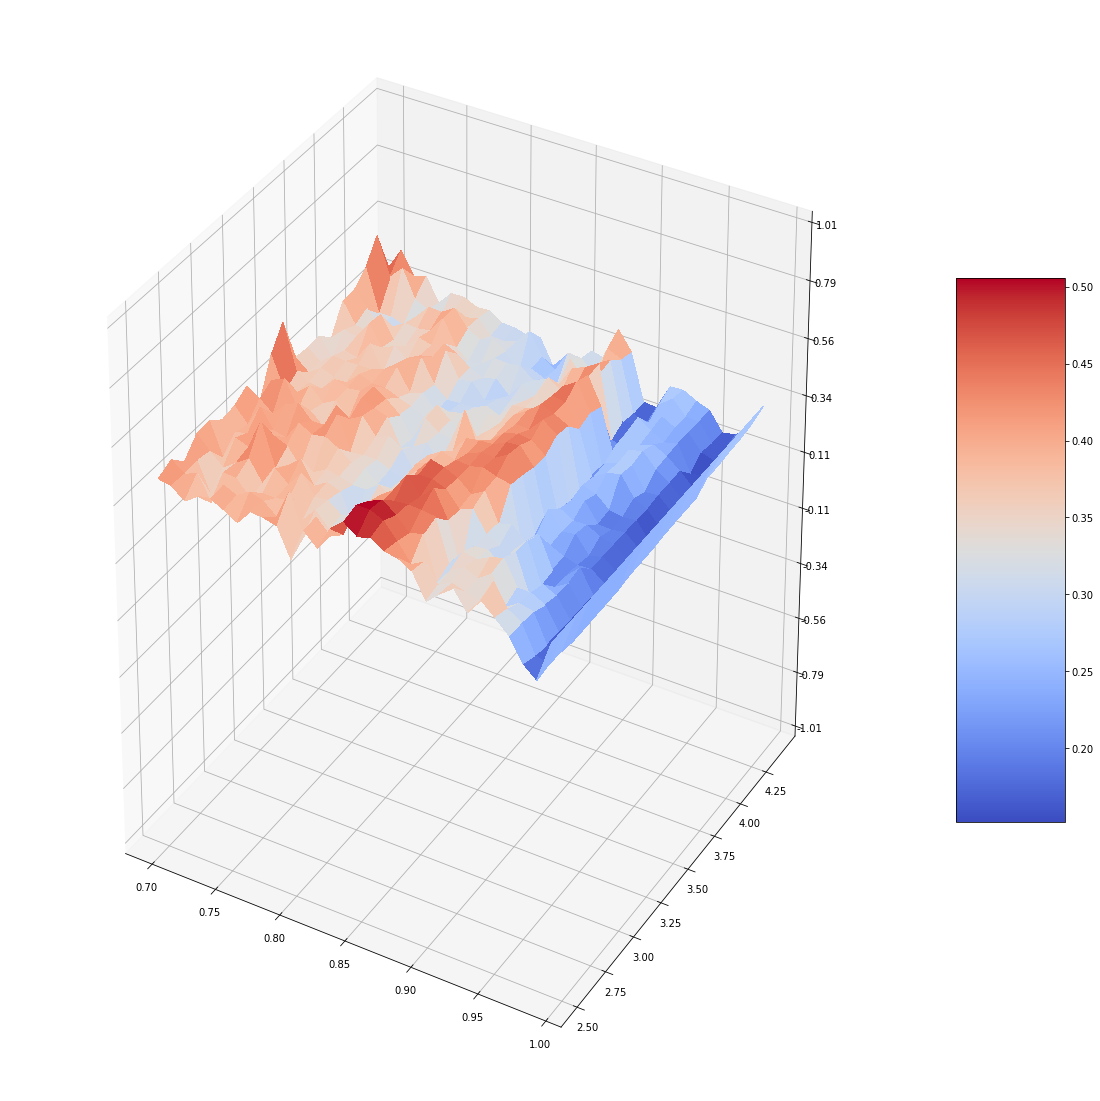

In [130]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(betas, gamas, func_result, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [118]:
Z.shape

(80, 80)